# PROJET DE NLP
# Classification des genres de film

### Chehouri Léa et Fromant Théophile

### ENSAE IPP 3A

Ce notebook est commenté, vous y trouverez les analyses détaillées de nos preprocessing et modèles. Une synthèse de notre projet est en pièce jointe, deux pages au format pdf.

Dans ce notebook vous pouvez trouver les parties suivantes:

1. ANALYSE DES VARIABLES ET PREPROCESSING 

    1.1. Variables numériques : budget, revenue, popularité, vote_avg, vote count
    
    1.2. Variable : title et original title
    
    1.3. Variable production company
    
    1.4. Variable belong to collection et tagline
    
    1.5. Variable cible : genre
        - analyse de la fréquence des genres
        - analyse du nombre de genre par film
        - pourcentage de film représenté par genre conservé
        - analyse de similarité entre les genres
        
    1.6. Variable textuelle : overview et title
        - analyse des longueurs des textes
        - analyse de la fréquence de symboles (%,#,@, nombre entier, flottant, années)
        - cleaning, preprocessing 
            - vérification de la langue
            - lower
            - suppression des liens, nombres, stop words, ponctuations, mots à moins de
               deux charactères.
            - normalisation des espaces blancs
            - correction de lorthographe avec SpellCheker
            - Lemmatisation
        - Analyse POS
        - Loi de Zipf
        - Word Clouds (fréquence des mots)
        - Tokenization
        - Profile Report      


2. MODÉLISATION

    2.1. Single-label classification
    
        2.1.1. Modèle de machine learning : baseling
            - Random Forest avec Bag of words
            - Random Forest avec Gloove embeddings et aggregation des embeddings par 
             moyenne simple
            - Random Forest avec Gloove embeddings et aggregation des embeddings par 
             moyenne Tf-Idf
            
        2.1.2. Modèle de deep learning : LSTM
            - LSTM avec couche de embeddings
            - LSTM avec fasttext embeddings
            
        2.1.3. Modèle préentrainé : BERT 
        
    2.2. Multi-labels classification
        - LSTM
        - One-vs-rest classifier
        
    2.3. Data Augmentation 
  


lien pour télécharger le dataset : https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv

# Imports

In [1]:
#pip install tensorflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import nltk 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter

from langdetect import detect
import string
import regex as re
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from spellchecker import SpellChecker

import gensim
import seaborn as sns
import itertools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer,StandardScaler

from nltk.stem.porter import *
import nltk

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer



2022-04-24 08:08:19.115574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 08:08:19.115605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Base de données

In [35]:
dataset_path = r"moviesdataset.csv"

In [36]:
df = pd.read_csv(dataset_path)
df = df.drop_duplicates()

/tmp/ipykernel_48/2259315201.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


In [37]:
print("La base contient %s films." %len(df))

La base contient 45453 films.


In [38]:
df.head()[:2]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------
# 1- ANALYSE DES VARIABLES 

Nous allons analyser chacune des variables pour juger de leur pertinence.

On peut supprimer certaines variables qui ne serviront pas à calculer les prédictions :

In [39]:
df = df.drop(columns=['adult','id','imdb_id','poster_path','status','video','homepage','spoken_languages','runtime','release_date','original_language','production_countries'])

In [40]:
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'original_title',
       'overview', 'popularity', 'production_companies', 'revenue', 'tagline',
       'title', 'vote_average', 'vote_count'],
      dtype='object')

### 1.1- Variables : budget, revenue, popularity, vote_average, vote_count

In [41]:
variable_to_describe = ['budget','revenue','popularity','vote_average', 'vote_count']

In [42]:
for var in variable_to_describe:
    perc = round((len(df[df[var].isna()])/len(df))*100,3)
    print("{} pourcent des films sont des NaN pour la variable {}".format(perc,var))
    df = df.dropna(subset=[var])
df.reset_index(drop = True, inplace = True)

0.0 pourcent des films sont des NaN pour la variable budget
0.013 pourcent des films sont des NaN pour la variable revenue
0.0 pourcent des films sont des NaN pour la variable popularity
0.0 pourcent des films sont des NaN pour la variable vote_average
0.0 pourcent des films sont des NaN pour la variable vote_count


In [43]:
for var in variable_to_describe:
    print("Le type de la variable {} est {}.".format(var,df['budget'].dtype))


Le type de la variable budget est object.
Le type de la variable revenue est object.
Le type de la variable popularity est object.
Le type de la variable vote_average est object.
Le type de la variable vote_count est object.




On convertit en float les deux variables.

In [44]:
def convert_to_float(x):
    try:
        return float(x)
    except:
        return None
    
for var in variable_to_describe:
    df[var] = df[var].apply(lambda x :convert_to_float(x))

In [45]:
var = df[variable_to_describe]
var.describe()

,budget,revenue,popularity,vote_average,vote_count
count,4.544700e+04,4.544700e+04,45447.000000,45447.000000,45447.000000
mean,4.226045e+06,1.121254e+07,2.921534,5.618199,109.918256
std,1.742702e+07,6.434117e+07,6.006039,1.924198,491.378000
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.385945,5.000000,3.000000
50%,0.000000e+00,0.000000e+00,1.127513,6.000000,10.000000
75%,0.000000e+00,0.000000e+00,3.679023,6.800000,34.000000
max,3.800000e+08,2.787965e+09,547.488298,10.000000,14075.000000


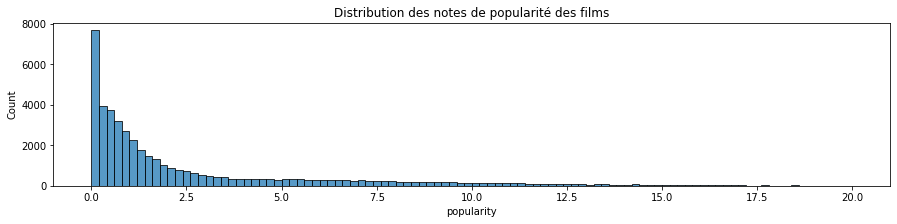

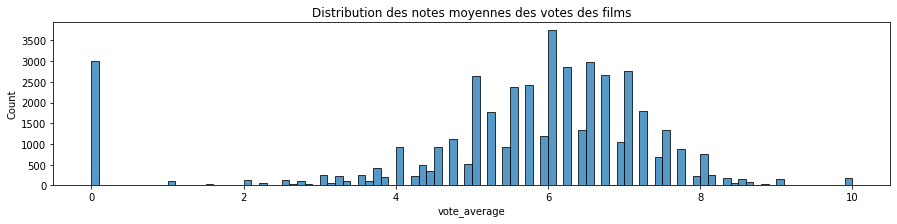

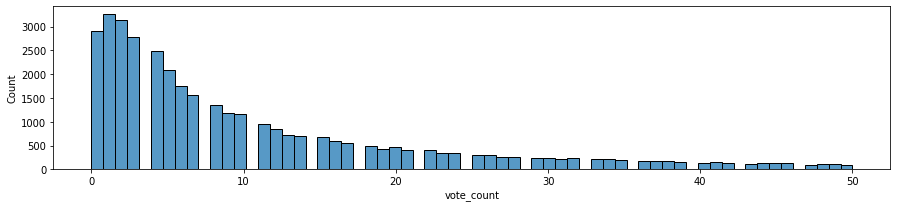

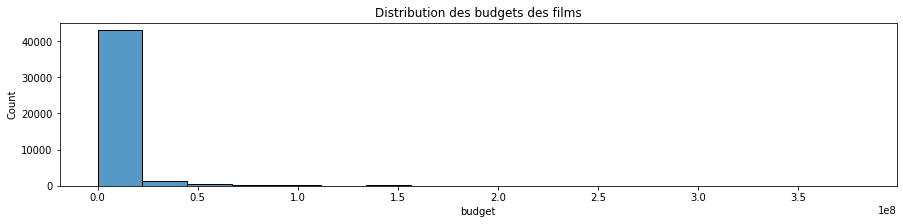

In [46]:
plt.figure(figsize = (15,3))
sns.histplot(df.popularity,binrange=(0,20),bins=100) 
plt.title("Distribution des notes de popularité des films")
plt.show()
plt.figure(figsize = (15,3))
sns.histplot(df.vote_average)
plt.title("Distribution des notes moyennes des votes des films")
plt.show()
plt.figure(figsize = (15,3))
sns.histplot(df.vote_count,binrange=(0,50))
"Distribution des nombre de votes des films"
plt.show()
plt.figure(figsize = (15,3))
sns.histplot(df.budget)
plt.title("Distribution des budgets des films")
plt.show()

Pour le revenu on voit que très très peu de films ont un revenu.
on voit que très peu de films sont très populaires.
On observe une répartition des valeurs en décroissance exponentielle pour le revenu et la popularity. Quelques rares films font de très gros bénéfices, et le reste n'en font quasiment pas.

### 1.2- Variable title et original title

Ces deux variables ont le même nombre de variable, et elle semblent a priori contenir à peu près les mêmes informations. Ainsi, nous décidons de garder uniquement la variable 'title'. Nous la traitons de la même manière que nous avons traité les données des overviews. 

In [23]:
for var in ['title','original_title']:
    perc = round((len(df[df[var].isna()])/len(df))*100,3)
    print("{} pourcent des films sont des NaN pour la variable {}".format(perc,var))

0.0 pourcent des films sont des NaN pour la variable title
0.0 pourcent des films sont des NaN pour la variable original_title


In [47]:
df = df.drop(columns=['original_title'])

### 1.3 Variable production company

On doit nettoyer cette variable comme pour la variable genre.

Cette variable peut potentiellement être très intéressante. Effectivement, parmi toutes nos variables, celles qui à priori vont permettre au mieux de prédire les genres, sont les overviews. Or, certains genres, comme le genre animation, est difficilement reconnaissable par son résumé. Par contre, il est facilement reconnaissable par la compagnie de production ! Effectivement, si la companie de production est, par exemple, Pixar, alors il y a de fortes chances que le genre soit animation.

In [48]:
def clean_variable_genre(var):
    try:
        var = literal_eval(var)
        names = [i['name'] for i in var]
    except:
        names = []
    return names
df['production_companies'] = df.production_companies.apply(clean_variable_genre)
df.production_companies.apply(lambda x : len(x)).describe()

#df['production_companies'] = df.production_companies.apply(lambda x : x[0])

count    45447.000000
mean         1.551390
std          1.742031
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: production_companies, dtype: float64

In [49]:
t = list(df['production_companies'])
prod_companies_list = [item for sublist in t for item in sublist]
prod_companies_dic = Counter(prod_companies_list)
prod_companies_dic_sorted = dict(sorted(prod_companies_dic.items(), key=lambda item: item[1],reverse=True))
print("Les films ont plusieurs companies de production differentes")
print("Il y a %s companies de production differentes" %len(prod_companies_dic_sorted.keys()))

Les films ont plusieurs companies de production differentes
Il y a 23537 companies de production differentes


In [50]:
#plt.figure(figsize = (13,5))
#plt.bar(list(prod_companies_dic_sorted.keys()),list(prod_companies_dic_sorted.values()),width=0.8, color='g')
#plt.tick_params(axis = 'x', labelsize = 7)
#plt.title("Frequence d'appariton des genres")
#plt.show()

Par soucis de simplicité, on garde une companie de production par film et on garde la companie de production la plus populaire.

In [51]:
companies_sorted = list(prod_companies_dic_sorted.keys())

def get_top_production_companie(prod_list):
    indexes = []
    for pl in prod_list:
        indexes.append(companies_sorted.index(pl))
    try:
        r = companies_sorted[min(indexes)]
    except:
        r = ''
    return r
 
df['top_production_companies'] = df.production_companies.apply(get_top_production_companie)

df = df.drop(columns=['production_companies']).reset_index().drop(columns=['index'])

print("En gardant que la premiere companie de production la plus populaire pour chaque film, on a encore %s companie de production differents" %len(df['top_production_companies'].unique()))

En gardant que la premiere companie de production la plus populaire pour chaque film, on a encore 9673 companie de production differents


On aurait voulu obtenir moins de production companies pour pouvoir encoder la variable en dummies, mais on a beaucoup trop de catégories. On pourrait encoder la vairiable textuel en embeding mais je doute de la pertinence de ceci. Il vaut mieux omettre la variable.

In [52]:
df = df.drop(columns=['top_production_companies'])

### 1.4 Variable belongs_to_collection et tagline

La variable belongs_to_collection est codée de la même manière que celle du genre. Elle peut être assez utile pour la prédiction de genre mais il semble qu'elle ait beaucoup de valeur manquante.

Effectivement, seulement 10% des données ont des valeurs non manquantes pour cette variable, ainsi, on decide de ne pas tenir compte de cette variable. Pareil pour la variable tagline avec plus de la moitié des Nan.


In [53]:
for var in ['belongs_to_collection','tagline']:
    perc = round((len(df[df[var].isna()])/len(df))*100)
    print("{} pourcent des films sont des NaN pour la variable {}".format(perc,var))
    
df = df.drop(columns=['belongs_to_collection','tagline']) 

90 pourcent des films sont des NaN pour la variable belongs_to_collection
55 pourcent des films sont des NaN pour la variable tagline


### 1.5 Variable cible : genre 

On commence par créer une variable new_genre qui transforme les éléments de la colonne genres en liste. 
La fonction literal_eval permet de faire cela.

In [54]:
def clean_variable_genre(var):
    try:
        var = literal_eval(var)
        names = [i['name'] for i in var]
    except:
        names = []
    return names
df['new_genre'] = df['genres'].apply(clean_variable_genre)

#### Analyse des genres

In [55]:
all_genres = df.new_genre.values 
all_genres = list(all_genres)
all_genres = [item for sublist in all_genres for item in sublist]
occ_genres = Counter(all_genres)
occ_genres_sorted = dict(sorted(occ_genres.items(), key=lambda item: item[1],reverse=True))

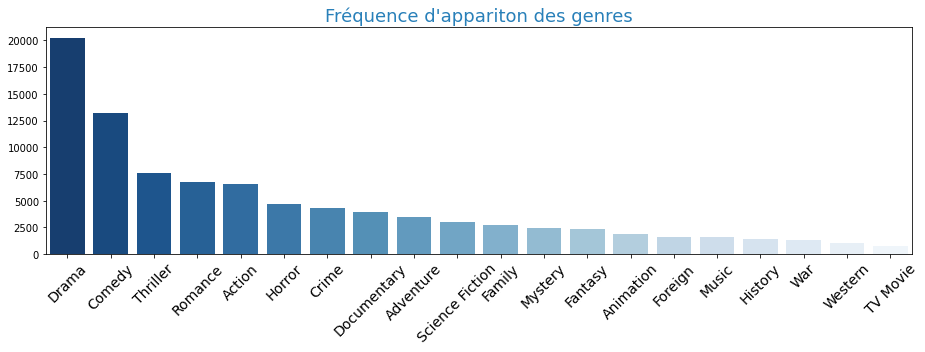

In [58]:
plt.figure(figsize = (13,5))
sns.barplot(list(occ_genres_sorted.keys()),list(occ_genres_sorted.values()),palette="Blues_r")
plt.tick_params(axis = 'x', labelsize = 14)
plt.title("Fréquence d'appariton des genres", fontsize=18, color='#2980b9')
plt.xticks(rotation= 45)
plt.tight_layout()

Ainsi, on peut voir que les genres les plus fréquents sont Drama, Comedy, Thriller, Romance, Action, Horror, Crime, Documentary ... Regardons maintenant le nombre de genre attribué par film.

In [59]:
df['nb_genre'] = df.new_genre.apply(lambda x :len(x))
occ_nb_genres = Counter(df['nb_genre'])

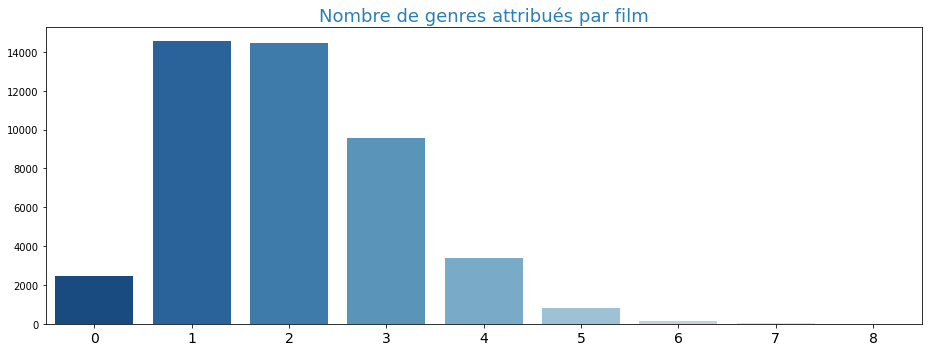

In [64]:
plt.figure(figsize = (13,5))
sns.barplot(list(occ_nb_genres.keys()),list(occ_nb_genres.values()),palette="Blues_r")
plt.tick_params(axis = 'x', labelsize = 14)
plt.title("Nombre de genres attribués par film", fontsize=18, color='#2980b9')
plt.tight_layout()

On voit qu'il y a des films qui n'ont pas de genre attribué (et qui n'ont pas été codé par des NaN dans la base originale). Il faut donc qu'on les retirer.

Un film peu avoir jusqu'a 6 genres attribués, mais cela reste très rare. En général, les films ont entre 1 et 3 genres attribués.

Cette information est intéressante. Si un film peut avoir plusieurs genres on peut se demander si un sous ensemble de genres peut décrire la totalité de la base. Ceci serait assez pratique, puisque, dans un premier temps, nous comptons faire de la multi-classification, et un trop grand nombre de classe peut engendrer des résultats peu satisfaisants. 

Il serait donc intéressant de trouver un sous ensemble de genres qui décrivent la totalité ou une grande proportion de la base de données.

Pour ce faire, nous regardons combien de films n'ont pas de genre associé parmi les x genres les plus populaires.

In [65]:
# On creer des variables dummies pour les genres
def is_genre(lst,genre):
    if genre in lst:
        return 1
    else:
        return 0
    
columns_to_add = list(occ_genres.keys()) #[:-12]
for col in columns_to_add:
    df[col] = df.new_genre.apply(lambda x: is_genre(x,col)) 
    

In [66]:
# On creer la variable du genre principale pour chaque film : qui correpond au genre le plus populaire
def get_key(val,my_dict):
    for key, value in my_dict.items():
         if val == value:
                return key
            
genres_importance_values = sorted(list(occ_genres.values())) #[:-12]
genres_importance = [get_key(val,occ_genres) for val in genres_importance_values]
genres_importance.reverse()

def get_genre_principal(genres_importance,lst):
    for genre in genres_importance:
        if genre in lst:
            return genre
    

df['genre_principal'] = df.new_genre.apply(lambda x: get_genre_principal(genres_importance,x))
df = df[df['genre_principal'].isna()==False]

La variable correspond au genre le plus populaire parmi les genres attribués au film.

In [67]:
df = df.drop(['genres','new_genre'],1)

On regarde le nombre de film décrit par les 'nb_genre_pop_garde' genres les plus populaires :

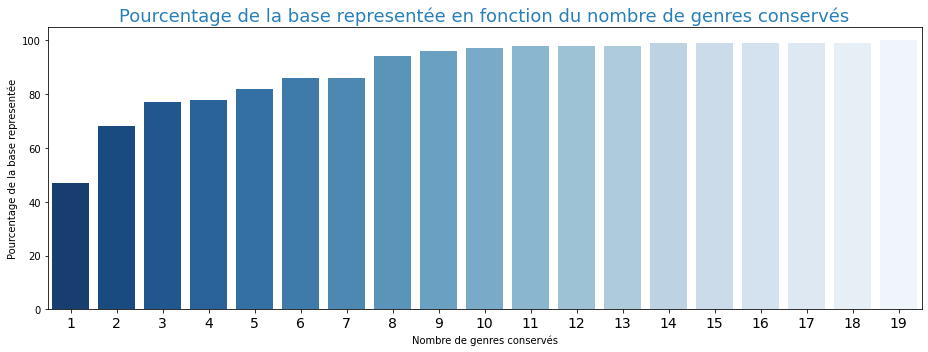

In [68]:
# Representation graphique 
perc_table = []
for i in range(1,20):
    genres_to_keep = list(occ_genres_sorted.keys())[:i]
    table_to_keep = df[df['genre_principal'].isin(genres_to_keep)]
    perc_table.append(round((len(table_to_keep)/len(df))*100))

    
plt.figure(figsize = (13,5))
ax = sns.barplot(list(range(1,20)),perc_table,palette="Blues_r")
ax.set(xlabel='Nombre de genres conservés', ylabel='Pourcentage de la base representée')
plt.tick_params(axis = 'x', labelsize = 14)
plt.title("Pourcentage de la base representée en fonction du nombre de genres conservés", fontsize=18, color='#2980b9')
plt.tight_layout()
plt.show()

In [69]:
nb_genre_pop_garde = 8
genres_to_keep = list(occ_genres_sorted.keys())[:nb_genre_pop_garde]
table_to_keep = df[df['genre_principal'].isin(genres_to_keep)]
print("Pourcentage des films pris en compte lorsque l'on garde les",nb_genre_pop_garde," genres les plus populaires:", round((len(table_to_keep)/len(df))*100),"%")

Pourcentage des films pris en compte lorsque l'on garde les 8  genres les plus populaires: 94 %


On voit que le genre Drama represente à lui seul 45% de la base. 

Au vu du graphique, le plus pertinent est de conserver 8 genres : on représente 94% de la base, et en garder plus que 8 n'augmente pas particulièrement le pourcentage de la base conservée.

#### Analyse de similarité des genres

Au vu des word cloud (cf apres), on peut anticiper que certains genres sont assez proche, similaire. On aimerait alors faire une étude de proximité des genres pour voir si potentiellement on peut regrouper des genres.

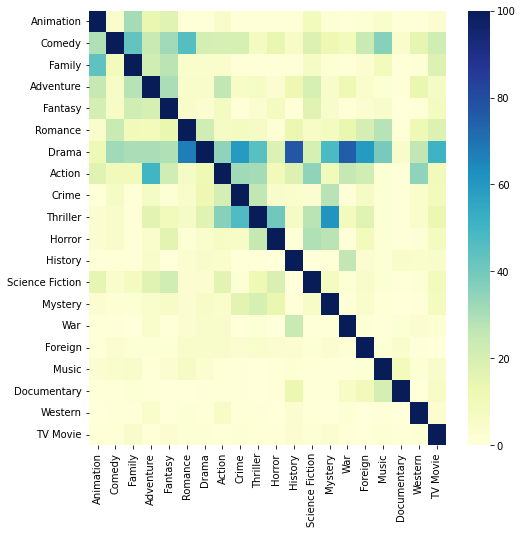

In [70]:
var_genre = ['Animation', 'Comedy', 'Family', 'Adventure'
       ,'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
       'Documentary', 'Western', 'TV Movie']

conf = []
for var in var_genre:
    arr = []
    t = df[df[var]==1]
    l = len(t)
    for varr in var_genre:
        arr.append(round((len(t[t[varr]==1])/l)*100))
    conf.append(arr)

cf_matrix = pd.DataFrame(data = conf,columns = var_genre,index=var_genre)
import seaborn as sns
plt.figure(figsize = (8,8))
sns.heatmap(cf_matrix.T,cmap="YlGnBu")
plt.show()

A priori, on voit que le genre le plus associé à d'autres genres est le genre Drama. C'est intéressant car c'est également le genre le plus prépondérant (la classe des genres drama est particulièrement grosse par rapport aux autres, elle représentent presque la moitié des films), ainsi, on pourrait tester un algorithme en ommetant cette classe pour essayer d'être plus performant sur les petites classes.   

Il est intéréssant de noter également que la matrice est assez peu symétrique, cela veut dire que si le genre A est fortement associé au genre B, l'inverse n'est pas forcement vrai. On a a peu pres équivalence pour les genre Crime et Thriller, et thriller et horror.
Drama et Romance sont relativement proche aussi, ainsi que Comedy et Family.

A priori, plus les genres sont proche, plus ils seront difficile à distinger.

### 1.6 Variable textuelle : overview, title

In [71]:
df = df.dropna(subset=['overview'])
df.reset_index(drop = True, inplace = True)

In [ ]:
#df[['overview','genre_principal']].to_csv("movies_for_DA.csv")

#### Longueur du texte

In [72]:
print("La longueur moyenne des overviews est",df.overview.apply(len).mean())

La longueur moyenne des overviews est 323.430675049636


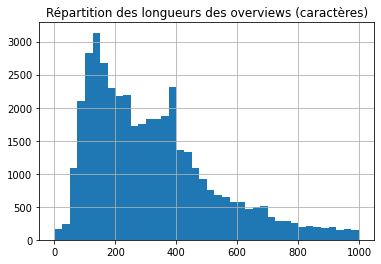

In [73]:
%matplotlib inline
df.overview.apply(len).hist(bins=40)
plt.title("Répartition des longueurs des overviews (caractères)")
plt.show()

In [74]:
df.overview.apply(len).describe()

count    42308.000000
mean       323.430675
std        203.536190
min          1.000000
25%        160.000000
50%        283.000000
75%        428.000000
max       1000.000000
Name: overview, dtype: float64

#### Analyse des symboles dans les overviews

In [75]:
import re
# Regular expression that matches any sequence of numbers:
at_prog = re.compile('@')
hash_prog = re.compile('#')
int_prog = re.compile('[0-9]+')
float_prog = re.compile('[0-9]+\.?[0-9]*')
percent_prog = re.compile('[0-9]+\.?[0-9]*%')
year_prog = re.compile('[12][089][0-9][0-9]') # a year between 1800 and 2099. # 1[89][0-9][0-9]|20[0-9][0-9]
df1 = df.drop_duplicates('overview')  # Don't forget to compute over unique elements if it applies
# Calculating number of matches for every abstract
progs = [at_prog,hash_prog,int_prog, float_prog, percent_prog, year_prog]
nb_types = ['@','#','ints', 'floats', 'percents', 'years']
for prog, nb_type in zip(progs, nb_types):
    df1[nb_type] = df1['overview'].apply(lambda x: len(prog.split(x))-1).array
df1[nb_types].head()

,@,#,ints,floats,percents,years
0,0,0,0,0,0,0
1,0,0,1,1,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [76]:
nb_percent_types = [''.join([t, '%']) for t in nb_types]
# Don't forget to compute over unique abstracts
df1 = df.drop_duplicates('overview')

for prog, nb_type in zip(progs, nb_percent_types):
    df1[nb_type] = df1['overview'].apply(lambda x: 100 *(1 - len(''.join(prog.split(x)))/len(x))).array
df1[nb_percent_types+['overview']].head()

,@%,#%,ints%,floats%,percents%,years%,overview
0,0.0,0.0,0.000000,0.000000,0.0,0.0,"Led by Woody, Andy's toys live happily in his ..."
1,0.0,0.0,0.506329,0.506329,0.0,0.0,When siblings Judy and Peter discover an encha...
2,0.0,0.0,0.000000,0.000000,0.0,0.0,A family wedding reignites the ancient feud be...
3,0.0,0.0,0.000000,0.000000,0.0,0.0,"Cheated on, mistreated and stepped on, the wom..."
4,0.0,0.0,0.000000,0.000000,0.0,0.0,Just when George Banks has recovered from his ...


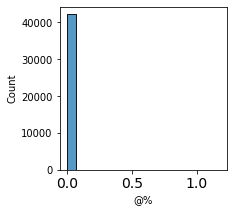

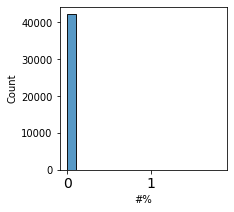

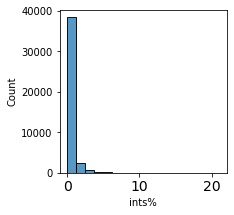

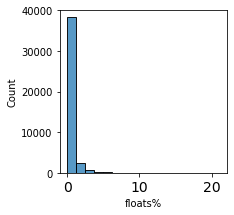

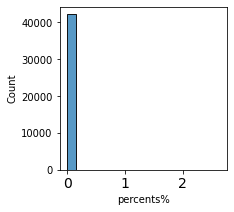

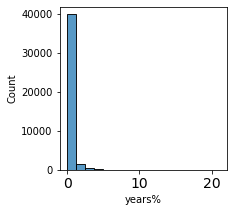

In [77]:
for nbp in nb_percent_types:
    plt.figure(figsize = (3,3))
    sns.histplot(df1[nbp])
    plt.tick_params(axis = 'x', labelsize = 14)
    plt.show()

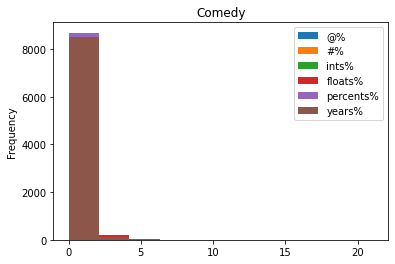

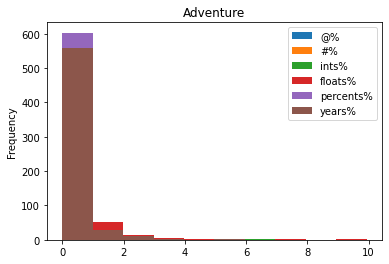

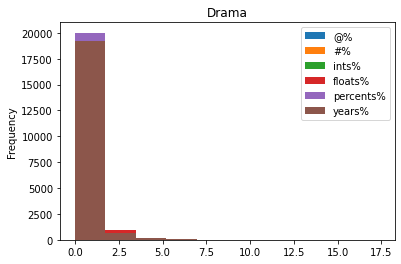

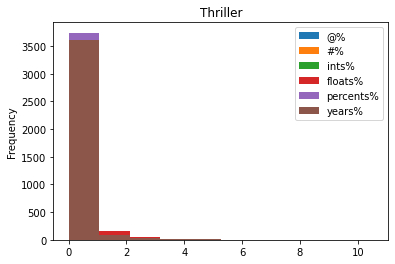

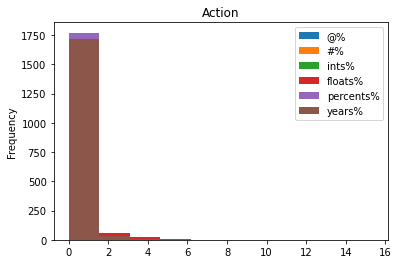

In [79]:
# repartition des regex par categorie

categories = list(df.genre_principal.drop_duplicates().values)[:5]
for category in categories:
    is_category = df['genre_principal']==category
    df1 = df[is_category]
    nb_percent_types = [''.join([t, '%']) for t in nb_types]
    for prog, nb_type in zip(progs, nb_percent_types):
        df1[nb_type] = df1['overview'].apply(lambda x: 100 *(1 - len(''.join(prog.split(x)))/len(x))).array
        # df1[nb_percent_types+['content']].head()
        # df1[nb_percent_types].hist()
    ax = df1[nb_percent_types].plot(kind='hist',subplots=False,sharex=True,sharey=True,title='%s' % (category))


Il y a que très peu de symboles %,#,ints,floats,@,année, et ceux quelques soit la classe. On voit juste que pour le genre War, il y a relativement beaucoup dannées qui resortent, ce qui est assez logique.

#### CLEANING - PREPROCESSING

Pour le preprocessing, on :

    - vérifie la langue
    - on décontracte les contractions en anglais
    - on met tout en minuscule
    - on retire les links, les nombres, les stop words, la ponctuation, les mots à moins de deux charactères
    - on normalise les espaces
    - on corrige les fautes dorthographes avec SpellCheker
    - on lemmatise
    

In [80]:
import contractions

punctuation = string.punctuation
spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
#spell = SpellChecker()
sp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer(language='english')

def language(text):
    try:
        return detect(text)
    except:
        return np.nan
    
def expand_word(text):
    expanded_words = []
    for word in text.split():
        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))
    expanded_text = ' '.join(expanded_words)
    #print('Original text: ' + text)
    #print('Expanded_text: ' + expanded_text)
    return ' '.join([ t for t in expanded_words])

def clean(text):
    text = text.lower() #lower case  
    text = re.sub(r'http[^\s]+', '', text) # Links removal
    text = re.sub(r'\d+', '', text) #Number Removal
    text = ' '.join([word for word in text.split(' ') if word.lower() not in stopwords]) #Stopword Removal
    text = expand_word(text) 
    text = text.translate(str.maketrans('', '', punctuation)) #Punctuation Removal
    text = re.sub(r"\W*\b\w{1,2}\b", '', text) #remove word with less than two caracter
    text = ' '.join(text.split()) #Whitespace Normalization
    #text = ' '.join([spell.correction(word) for word in text.split(' ')]) #Spelling Correction
    #text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    text = ' '.join([token.lemma_ for token in sp(text)])
    return text

Remarque : cette partie du preprocessing (nettoyer le text des ponctutions, nombres, stopwords ect.., aurait pu être implémenté dans les pipelines des modèles, mais comme nous allons tester plusieurs modèles, et donc implémenter plusieurs pipelines, et que ces calculs de néttoyage sont assez couteux, nous préfèrons les faire en amont plutôt que de les intégrer aux pipelines.

Dans un premier temps on vérifie que tous les films soit bien en anglais.

In [ ]:
# On retire les films dont la description n'est pas en anglais

df['language_overview'] = df.overview.apply(language)
dropped = len(df[df['language_overview']!='en'])
print("On a retiré %s films dont la description n'est pas en anglais" %dropped)
df = df[df['language_overview']=='en']
df = df.reset_index().drop(columns=['index','language_overview'])

In [ ]:
df['overview'] = df.overview.apply(clean)
df['title'] = df.title.apply(clean)

In [82]:
print("La longueur moyenne des overviews apres nettoyage sans les stop words est",df.overview.apply(len).mean())

La longueur moyenne des overviews apres nettoyage sans les stop words est 202.50401025105594


Avant nettoyage, la longueur moyenne est de 323.

#### POS analyse

In [83]:
df = pd.read_csv("moviesdataset_firstclean_all_genres.csv")

In [84]:
from spacy import displacy
from spacy.lang.en import English
#nlp = English()
nlp = spacy.load("en_core_web_sm")

# Visualizing Entities
for title in df.overview[:10]:
  doc = nlp(title)
  displacy.render(doc, style="ent",jupyter=True)

In [85]:
# Getting the entity Information (takes about 40s)
short_df = df[['overview']]
title_ent = short_df['overview'].apply(lambda x: [ent.label_ for ent in nlp(x).ents]).array

# Displaying the available entity types
ent_types = set(np.concatenate(title_ent))
print("Spacy recognizes {} entity types. "
"These types are the following:\n{}".format(len(ent_types), ent_types))

Spacy recognizes 18 entity types. These types are the following:
{'LANGUAGE', 'EVENT', 'LOC', 'PERCENT', 'MONEY', 'DATE', 'PERSON', 'GPE', 'ORG', 'PRODUCT', 'WORK_OF_ART', 'QUANTITY', 'ORDINAL', 'CARDINAL', 'FAC', 'NORP', 'TIME', 'LAW'}


In [86]:
# Getting counts for Every entity type
for ent_type in ent_types:
    ent_count = [sum([title_ent_ij==ent_type for title_ent_ij in title_ent_i]) for title_ent_i in title_ent]
    short_df[ent_type] = ent_count
short_df[ent_types].head()

,LANGUAGE,EVENT,LOC,PERCENT,MONEY,DATE,PERSON,GPE,ORG,PRODUCT,WORK_OF_ART,QUANTITY,ORDINAL,CARDINAL,FAC,NORP,TIME,LAW
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
for col in list(short_df.columns[1:]):
    print("Nombre de",col, ":",short_df[col].sum())

Nombre de LANGUAGE : 137
Nombre de EVENT : 416
Nombre de LOC : 830
Nombre de PERCENT : 1
Nombre de MONEY : 121
Nombre de DATE : 6059
Nombre de PERSON : 25940
Nombre de GPE : 12348
Nombre de ORG : 7324
Nombre de PRODUCT : 171
Nombre de WORK_OF_ART : 73
Nombre de QUANTITY : 64
Nombre de ORDINAL : 710
Nombre de CARDINAL : 1134
Nombre de FAC : 264
Nombre de NORP : 9862
Nombre de TIME : 1015
Nombre de LAW : 30


On retrouve particulièrement des noms de personnes, des noms de ville ou pays, ce qui est assez logique car ce sont des textes qui racontent des histoires.

#### Distribution des mots : Loi de Zipf


In [130]:
full = df['overview']
full = " ".join(full)

# We tokenize the whole corpus 
tokenizer = RegexpTokenizer("[\w']+") 
text = full
tokens = tokenizer.tokenize(text)
tokens = list(filter(lambda val: val !=  's', tokens))

# On compte les tokens distincts 
counts,values = pd.Series(tokens).value_counts().values, pd.Series(tokens).value_counts().index
instances1 = pd.DataFrame(list(zip(values,counts)),columns=["value","count"])

In [131]:
print('The vocabulay size is {}'.format(np.shape(instances1)[0]) )

instances1.head()

The vocabulay size is 71366


,value,count
0,life,8115
1,find,7256
2,man,6677
3,young,6576
4,film,6189


In [133]:
cumulative = np.cumsum(instances1["count"].tolist())
cumulative = cumulative/cumulative[-1] * 100

x = np.linspace(0, 100, len(instances1["value"].tolist()))

Text(0.5, 1.0, "Zipf's Law")

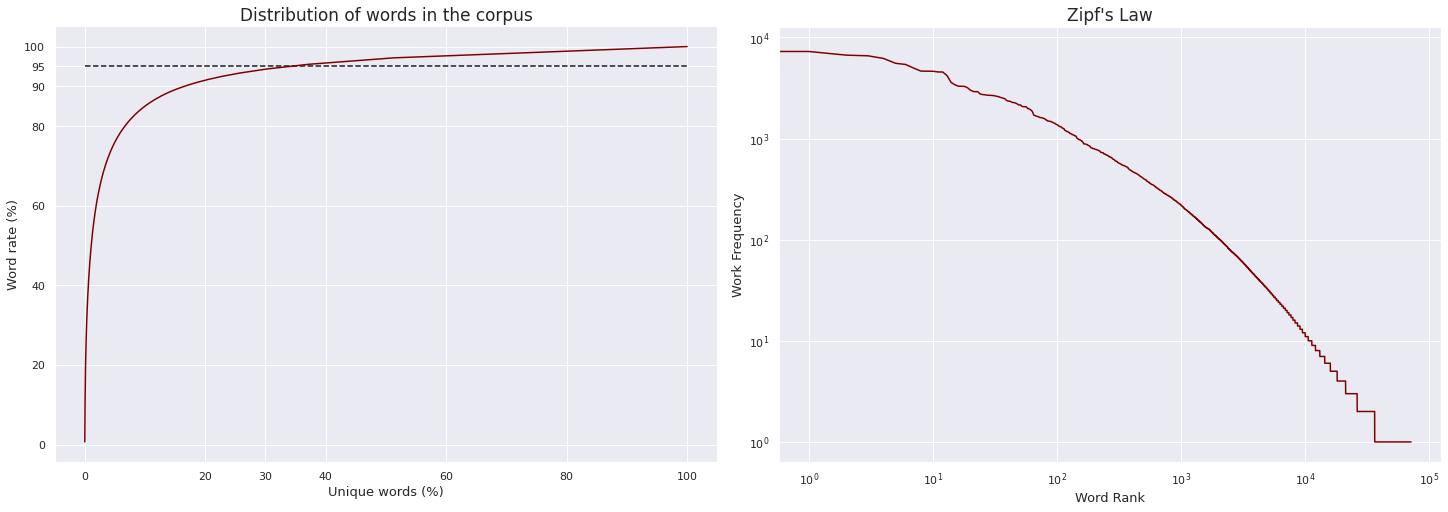

In [134]:
sns.set()

fig, (ax0, ax1) = plt.subplots(ncols = 2, constrained_layout = True, figsize = (20, 7))

ax0.plot([0, 100], [95, 95], '--k')
ax0.set_yticks([0, 20, 40, 60, 80, 90, 95, 100], minor=False)
ax0.set_xticks([0, 20, 30, 40, 60, 80, 100], minor=False)
ax0.plot(x, cumulative, color = 'maroon')
ax0.set_xlabel('Unique words (%)', size = 13)
ax0.set_ylabel('Word rate (%)', size = 13)
ax0.set_title('Distribution of words in the corpus', size = 17)

#removing top and right borders
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


ax1.set_yticks([0, 20, 40, 60, 80, 90, 95, 100], minor=False)
x1 = np.arange(0, np.shape(instances1)[0], 1)
ax1.plot(x1, instances1["count"].tolist(), color = 'maroon')
plt.xscale('log')
plt.yscale('log')
ax1.set_xlabel('Word Rank', size = 13)
ax1.set_ylabel('Work Frequency', size = 13)
ax1.set_title('Zipf\'s Law', size = 17)

Nous observons que seulement 30% des mots du vocabulaire représentent 95% des mots du
corpus. A droite, nous avons une représentation, dans un système de coordonnées log-log, de la fréquence d’un mot du corpus selon son rang dans l’ordre des fréquences.Par exemple, le dixième mot le plus représenté dans le corpus apparaît à 6000 occurrences. La courbe formée par cette représentation n’est pas une droite comme le prévoit la loi de Zipf. Il aurait été intéressant de voir la différence de répartition des mots avant et après avoir retiré les stop words.

#### Distribution des mots : WordCloud par genre de film

In [139]:
# On creer un dataset pour chaque label
data = []
for i in df['genre_principal'].unique():
    eap = df[df['genre_principal'] == i]
    full = eap['overview']
    full = " ".join(full)
    # We tokenize the whole corpus 
    tokenizer = RegexpTokenizer("[\w']+") 
    text = full
    tokens = tokenizer.tokenize(text)
    tokens = list(filter(lambda val: val !=  's', tokens))

    # We count the distinct tokens
    counts,values = pd.Series(tokens).value_counts().values, pd.Series(tokens).value_counts().index
    instances1 = pd.DataFrame(list(zip(values,counts)),columns=["value","count"])
    data.append(instances1)

In [140]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.render()
        
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    l = html_str.replace('table','table style="display:inline"')
    return l

In [141]:
df1 = data[0].head(10).style.set_caption('Label Comedy')
df2 = data[1].head(10).style.set_caption('Label Drama')
df3 = data[2].head(10).style.set_caption('Label Thriller') 
df4 = data[3].head(10).style.set_caption('Label Action') 
df5 = data[4].head(10).style.set_caption('Label Romance') 
df6 = data[5].head(10).style.set_caption('Label Horror') 
df7 = data[6].head(10).style.set_caption('Label Documentary') 
df8 = data[7].head(10).style.set_caption('Label Crime') 

In [142]:
l = display_side_by_side(df1, df2, df3, df4, df5, df6, df7,df8)

,value,count
0,find,1506
1,life,1302
2,new,1280
3,man,1231
4,love,1134
5,friend,1114
6,young,907
7,film,903
8,comedy,826
9,live,810


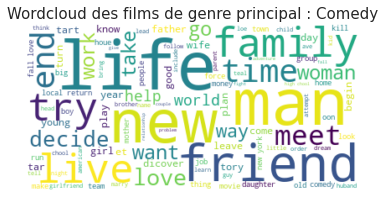

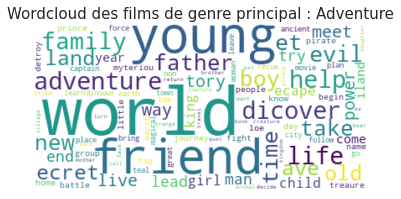

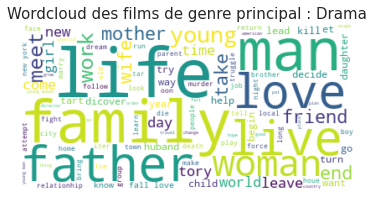

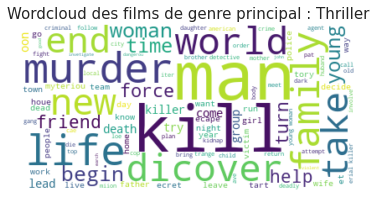

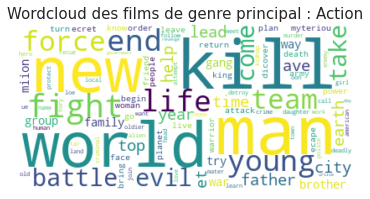

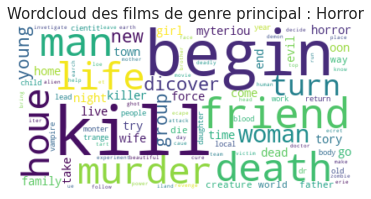

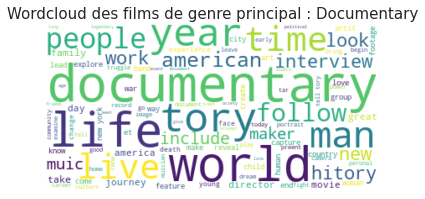

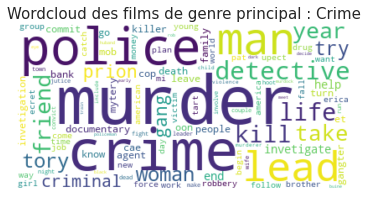

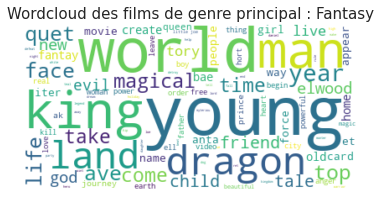

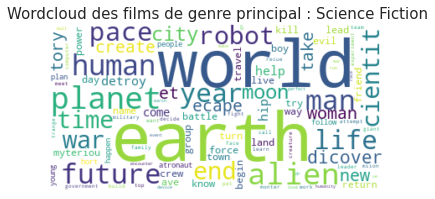

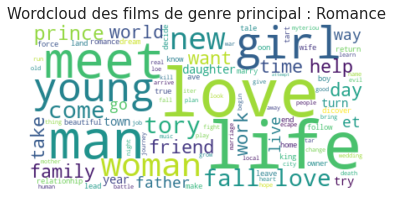

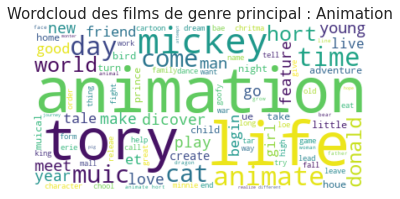

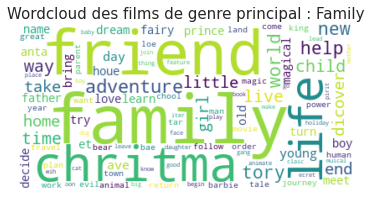

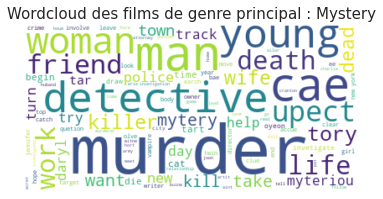

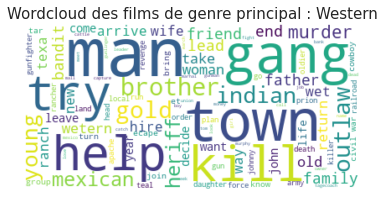

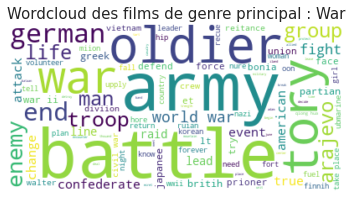

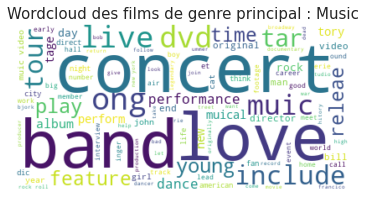

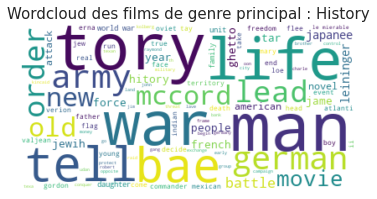

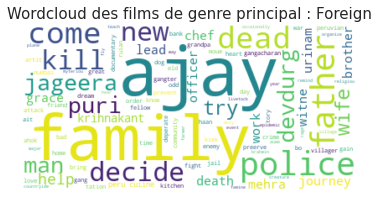

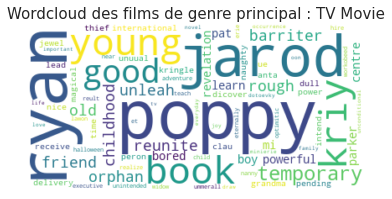

In [144]:
fontsize=15
# Start with one review:
for i in df['genre_principal'].unique():
    eap = df[df['genre_principal'] == i]
    full = eap['overview']
    full = " ".join(full)
    # We tokenize the whole corpus 
    #tokenizer = RegexpTokenizer("[\w']+") 
    text = full
    text = text.replace('find','')
    text = text.replace('film','')
    text = text.replace('s','')
    #tokens = tokenizer.tokenize(text)
    #Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=80, max_words=100,background_color="white").generate(text)

# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Wordcloud des films de genre principal : %s"%i, fontdict={'fontsize': fontsize})
    plt.axis("off")
    plt.show()

On observe que les wordclouds des différents genres sont très distincts, chaque genre a vraiment des mots propre à celui ci. Cest très intéressant car cela justifie bien lusage dun bag of word pour encoder nos overviews.

In [145]:
arr = df.overview.drop_duplicates().apply(lambda x: x.split(' ')).array
arr = [ x for X in arr for x in X]
print('%s "mots" dans les overviews après nettoyage.' % (len(set(arr)) ) )

71465 "mots" dans les overviews après nettoyage.


#### Tokenization

On teste différente technique de tokenization.

In [146]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer(),Tokenizer(nlp.vocab)]
import pdb # python debugger
#for tok in tqdm(tokenizers):
#    print('Using tokenizer: %s' % (tok))
#    arr = df.overview.apply(lambda x: tok.tokenize(x)).array
#    arr = [ x for X in arr for x in X]
#    print('Les 30 premiers tokens: %s' % (arr[:30]) )
#    print("Taille du vocabulaire: {0} avec {1} tokenizer".format(len(set(arr)), tok))
#    print('='*5) 

Les trois méthodes ont l'air relativement identique.

In [147]:
tokenizer = Tokenizer(nlp.vocab)

# Repeating the earlier vocabulary count
arr = df.overview.apply(lambda x: [w.text for w in tokenizer(x)]).array
df['tokens'] = arr
arr_s = [ x for X in arr for x in X]
print("Vocabulary size with Spacy's tokenizer: {}".format(len(set(arr_s))))

# Inspecting a tokenization sample
tokenization_sample = df.overview.head().apply(lambda x: 
                                              [w.text for w in tokenizer(x)])
print("Tokenization sample:\n {}".format(tokenization_sample))

Vocabulary size with Spacy's tokenizer: 71465
Tokenization sample:
 0    [lead, woody, andys, toy, live, happily, room,...
1    [sibling, judy, peter, discover, enchant, boar...
2    [family, wedding, reignite, ancient, feud, nex...
3    [cheat, mistreat, step, woman, hold, breath, w...
4    [george, bank, recover, daughter, wedding, rec...
Name: overview, dtype: object


On créer deux tables : une ou l'on garde que les 8 genres principaux pour faire de la multi-classification single-label, et une autre avec tous les genres, pour faire de la multi-label classification, en seconde partie.

In [149]:
#df = df.drop(['ints','floats', 'percents', 'years'],1)

In [ ]:
df.to_csv(r"moviesdataset_firstclean_all_genres.csv")

In [150]:
print("Apres le nettoyage, on a gardé %s pourcent de la base initial" %round((len(df)/45466)*100))

Apres le nettoyage, on a gardé 93 pourcent de la base initial


In [151]:
df = df[df['genre_principal'].isin(genres_to_keep)]
print(len(df))
df['genre_principal'].unique()

39771


array(['Comedy', 'Drama', 'Thriller', 'Action', 'Horror', 'Documentary',
       'Crime', 'Romance'], dtype=object)

In [152]:
print("Apres le nettoyage, on a gardé %s pourcent de la base initial sur la table des 8 genres principaux" %round((len(df)/45466)*100))

Apres le nettoyage, on a gardé 87 pourcent de la base initial sur la table des 8 genres principaux


In [ ]:
df.to_csv(r"moviesdataset_firstclean.csv")

## ProfileReport

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="BBC News", html={"style": {"full_width": True}})
#profile.to_notebook_iframe()

---------------------------------------------------------------------------------------------------------------
# 2- MODÉLISATION

- 2.1- Single-label classification sur les 8 genres principaux
    - Machine learning : BoW, Glove + Random Forest
    - Deep learning : LSTM + Fastext
- 2.1- Multi-label classification
    - LSTM
    - One-vs-rest
- 2.3- Data-augmentation


### Fonctions pour les pipelines

Nous implémentons nos modèles sous forme de pipelines. Ces fonctions nous permettent d'intégrer les variables numériques à nos pipelines de modele :

In [153]:
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    #c = len(x.columns)-2
    #return x.iloc[:, 0:c] 
    return [record[:-3].astype(float) for record in x]

def get_title_data(x):
    #c = len(x.columns)-2
    #return x.iloc[:, c] 
    return [record[-2] for record in x]

def get_overview_data(x):
    #c = len(x.columns)-1
    #return x.iloc[:, c] 
    return [record[-1] for record in x]

transfomer_numeric = FunctionTransformer(get_numeric_data)
title_transformer_text = FunctionTransformer(get_title_data)
overview_transformer_text = FunctionTransformer(get_overview_data)

### Fonctions pour l'évaluation de nos modèles

In [154]:
# Ces fonctions nous permettent d'évaluer nos modèles

def f_scoring(model, score):
    evaluation = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits = 3, shuffle = True), scoring = score).mean()
    return evaluation
    
# For prediction of genre_principal
def conf_matrix(y_true, y_pred, title):
    C = confusion_matrix(y_true, y_pred)
        
    ConfMatrix = C / C.sum(axis=1)[:,None]
        
    plt.figure(figsize = (10, 5))
    ax = sns.heatmap(ConfMatrix, annot=True, cmap="Reds", fmt=".2f",
                xticklabels = ['1', '2', '3', '4', '5', '6', '7'], 
                yticklabels = ['1', '2', '3', '4', '5', '6', '7'])
    
   

    sns.set()

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)

    plt.xlabel('Predicted Class', fontsize = 12)
    plt.ylabel('True Class', fontsize = 12)
    #plt.title("Confusion Matrix", size = 14)
    plt.savefig(title+".pdf")
    
    return plt.show()


def plot(estimator, title) : 
    fig, ax = plt.subplots(1, 2, figsize=(17,5))

    sns.set()  # Reset seaborn settings to get rid of black background

    ax[0].plot(np.arange(1, len(estimator.history['acc'])+1, 1), estimator.history['acc'], 'o-', color = 'firebrick')
    ax[0].plot(np.arange(1, len(estimator.history['val_acc'])+1, 1), estimator.history['val_acc'],'o-', color = 'forestgreen')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Valid'], loc='upper left')
    ax[0].grid(ls = 'dashed')

    # Plot model loss over epochs
    ax[1].plot(np.arange(1, len(estimator.history['loss'])+1, 1), estimator.history['loss'], 'o-', color= 'firebrick')
    ax[1].plot(np.arange(1, len(estimator.history['val_loss'])+1, 1), estimator.history['val_loss'], 'o-', color = 'forestgreen')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Valid'], loc='upper left')
    ax[1].grid(ls = 'dashed')
    plt.savefig(title+".pdf");
    
    return


def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)


# 2.1- CLASSIFICATION SINGLE-LABEL 

Ici, on fait de la classification muticlasse sur 8 genres. On prédit un des 8 genres les plus populaire pour chaque film.

In [155]:
df = pd.read_csv(r"moviesdataset_firstclean.csv").drop(['Unnamed: 0'],1)
df = df[['budget', 'popularity', 'revenue', 'vote_average',
       'vote_count', 'genre_principal','tokens', 'title', 'overview']]

In [156]:
print(len(df))
df = df.dropna()
print(len(df))

39771
39310


In [157]:
var_a_predire = 'genre_principal'
X, y = np.array(df[['budget', 'revenue',
                    'popularity','vote_average',
                    'vote_count', 'title','overview']]), np.array(df[var_a_predire])


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, stratify = y)
# est-ce qu'on garde que le vocabulaire correspondant au X_train ?
#df['voc'] = df['overview'] + ' ' + df['title']
#voc = np.array(df['voc'])
voc = np.array(df['overview'])

## 2.1.1- MODÈLES DE MACHINE LEARNING

#### Differents Word Embedding avec une Random Forest
 Prérequis pour nos tâches de NLP

##### On doit donner des embeddings à nos mots (à nos overview) on utilise le modèle de Glove pour cela

### 2.1.1.1- BAG OF WORDS + RANDOM FOREST

Compte tenu des word cloud, on voit que les vocabulaires de chaque classe sont assez spécifique à la classe, ainsi, implémenter un bag of word peut être pertinent.

In [158]:
pipeline_randomforest_bow = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric),('scale', StandardScaler())
            ])),
             ('title_features', Pipeline([
                ('selector', title_transformer_text),
                ("count_vectorizer", CountVectorizer(analyzer=lambda x: x))
            ])),
             ('overview_features', Pipeline([
                ('selector', overview_transformer_text),
                ("count_vectorizer", CountVectorizer(analyzer=lambda x: x))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])


In [159]:
# On entraine le modele
rf_bow_model = pipeline_randomforest_bow
rf_bow_model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_numeric_data at 0x7f6952679b80>)),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('title_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_title_data at 0x7f6952679af0>)),
                                                                 ('count_vectorizer',
                                                                  CountVectorizer(analyzer=<function <lambda> at 0x7f6952679f70>))])),
                 

In [160]:
y_pred = rf_bow_model.predict(X_test);
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.20      0.00      0.01       352
      Comedy       0.38      0.10      0.16      1702
       Crime       0.00      0.00      0.00        46
 Documentary       0.61      0.11      0.18       678
       Drama       0.52      0.97      0.68      3938
      Horror       0.00      0.00      0.00       326
     Romance       0.00      0.00      0.00        83
    Thriller       0.60      0.00      0.01       737

    accuracy                           0.52      7862
   macro avg       0.29      0.15      0.13      7862
weighted avg       0.46      0.52      0.39      7862



In [161]:
f_scoring(rf_bow_model, score = 'accuracy')

0.5182397191240585

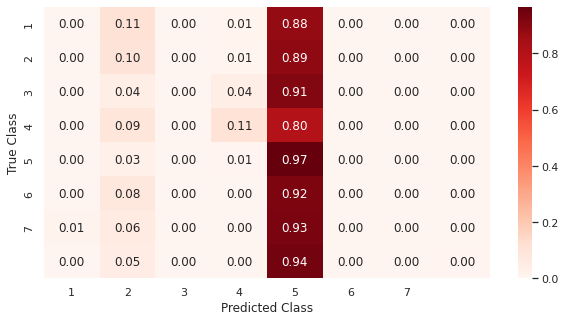

In [162]:
conf_matrix(y_test, y_pred, "Random forest with bag of word")

In [163]:
Counter(y_pred)

Counter({'Drama': 7289,
         'Documentary': 118,
         'Comedy': 445,
         'Action': 5,
         'Thriller': 5})

In [164]:
7265/len(y_pred)

0.9240651233782753

### 2.1.1.2- GLOVE + RANDOM FOREST

In [165]:
#Ici, on récupère les embeddings calcules avec glove pour notre vocabulaire (ie les mots de notre corpus)
#on récupère les embeddings d'un model qui a déjà été entrainé 
#l'ensemble des embedings de notre corpus est stockes dans glove_small

import struct 
GLOVE_6B_50D_PATH = r"glove.6B.50d.txt"
encoding="utf-8"
glove_small = {}
all_words = set(w for words in X for w in words)

with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

In [166]:
# Ici, on calcul les embeddings des mots de notre vocabulaire en utilisant word2vec
# on utilisera pas ces embedings finalement, on utilisera plutôt que glove

# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(voc, vector_size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index_to_key, model.wv.vectors)}

#### AGGREGATION DES EMBEDDINGS 

On test differentes techniques d'aggregation des embbedings : moyenne simple, ou moyenne Tf-idf.

In [167]:
# Ces classes permettent de traiter (ici d'agréger) nos embeddings de mots pour avoir un vecteur par résumé.

# Pour un résumé donné, on fait la moyenne des embeddings des mots du résumé, pour encoder notre variable résumé
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))]) # taille des embeddings
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# ici pareil, mais en version tf-idf avec les embedings
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
 

#### Moyenne des embeddings avec ponderation de la fréquence : méthode tf-idf

In [168]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data

# Use RandomForestClassifier 
pipeline_randomforest_tfidf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric),('scale', StandardScaler())
            ])),
             ('title_features', Pipeline([
                ('selector', title_transformer_text),
                ("glove vectorizer", TfidfEmbeddingVectorizer(glove_small))
            ])),
             ('overview_features', Pipeline([
                ('selector', overview_transformer_text),
                ("glove vectorizer", TfidfEmbeddingVectorizer(glove_small))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])


In [169]:
#On travaille sur gpu 
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
##if device_name != '/device:GPU:0':
 # raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

#X_train.to_device()
#y_train.to_device()

In [170]:
# On entraine le modele
rf_tfidf_model = pipeline_randomforest_tfidf
rf_tfidf_model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_numeric_data at 0x7f6952679b80>)),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('title_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_title_data at 0x7f6952679af0>)),
                                                                 ('glove '
                                                                  'vectorizer',
                                                                  <__main__.TfidfEm

On évalue notre modèle :

In [171]:
y_pred = rf_tfidf_model.predict(X_test);
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.50      0.01      0.01       352
      Comedy       0.38      0.07      0.11      1702
       Crime       0.00      0.00      0.00        46
 Documentary       0.43      0.04      0.07       678
       Drama       0.51      0.97      0.67      3938
      Horror       1.00      0.00      0.01       326
     Romance       0.00      0.00      0.00        83
    Thriller       0.50      0.01      0.01       737

    accuracy                           0.50      7862
   macro avg       0.41      0.14      0.11      7862
weighted avg       0.49      0.50      0.37      7862



In [172]:
f_scoring(rf_tfidf_model, score = 'accuracy')

0.5072246144328872

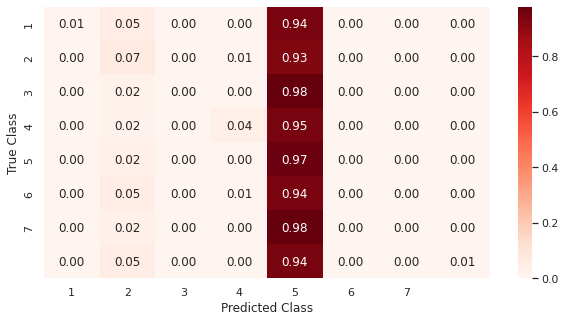

In [173]:
conf_matrix(y_test, y_pred, "Random forest Glove with tfidf mean embeding vectorizer")

In [174]:
# ON AURAIT PU FAIRE UN GRIDSEARCH POUR HYPERTUNNER NOTRE RANDOM FOREST (MAIS C'EST TRES LONG)

# Training config

# Grid Search Parameters for RandomForest
#param_grid = {'clf__n_estimators': np.linspace(1, 100, 10, dtype=int),
#              'clf__min_samples_split': [3, 10],
#              'clf__min_samples_leaf': [3],
#              'clf__max_features': [7],
#              'clf__max_depth': [None],
#              'clf__criterion': ['gini'],
#              'clf__bootstrap': [False]}

# Training config
#kfold = StratifiedKFold(n_splits=7)
#scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
#refit = 'F1'


# Perform GridSearch
#rf_tfidf_model = GridSearchCV(pipeline_randomforest_tfidf, param_grid=param_grid, cv=kfold, scoring=scoring, 
#                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
#rf_tfidf_model.to_device()
#rf_tfidf_model.fit(X_train, y_train)
#rf_tfidf_best = rf_tfidf_model.best_estimator_ 

#### Moyenne des embeddings simple

In [175]:
pipeline_randomforest_mev = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric),('scale', StandardScaler())
             ])),
             ('title_features', Pipeline([
                ('selector', title_transformer_text),
                ("word2vec vectorizer", MeanEmbeddingVectorizer(glove_small))
            ])),
             ('overview_features', Pipeline([
                ('selector', overview_transformer_text),
                ("word2vec vectorizer", MeanEmbeddingVectorizer(glove_small))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])


In [176]:
#on entraine le modèle
rf_mev_model = pipeline_randomforest_mev
rf_mev_model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_numeric_data at 0x7f6952679b80>)),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('title_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_title_data at 0x7f6952679af0>)),
                                                                 ('word2vec '
                                                                  'vectorizer',
                                                                  <__main__.Mean

In [177]:
# ON AURAIT PU FAIRE LA MEME GRID SEARCH

#rf_mev_model = GridSearchCV(pipeline_randomforest_mev, param_grid=param_grid, cv=kfold, scoring=scoring, 
#                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
#rf_mev_model.fit(X_train, y_train)
#rf_mev_best = rf_mev_model.best_estimator_

On évalue notre modèle :

In [178]:
# évaluation du modèle
y_pred = rf_mev_model.predict(X_test);
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Action       0.38      0.01      0.02       352
      Comedy       0.40      0.06      0.11      1702
       Crime       0.00      0.00      0.00        46
 Documentary       0.41      0.04      0.08       678
       Drama       0.51      0.97      0.67      3938
      Horror       1.00      0.00      0.01       326
     Romance       0.00      0.00      0.00        83
    Thriller       0.50      0.01      0.02       737

    accuracy                           0.51      7862
   macro avg       0.40      0.14      0.11      7862
weighted avg       0.48      0.51      0.37      7862



In [179]:
f_scoring(rf_mev_model, score = 'accuracy')

0.507631616781239

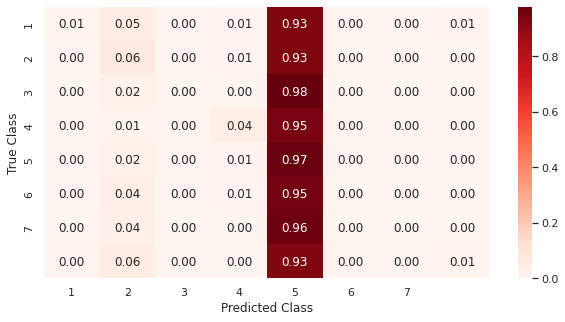

In [180]:
conf_matrix(y_test, y_pred, "Random forest Glove with mean embeding vectorizer")

Pas de grande différence entre ces techniques d'embbedings, les performances sont relativement identiques. On remarque que nos modèles ne prédisent que très peu de classe, cest une conséquence directe de nos classes déséquilibrées.

## 2.1.2- MODÈLES DE DEEP LEARNING

### 2.1.2.1- LSTM

Ici, notre LSTM aura 8 neurones en sortie, mais force la somme des probas à être égale à 1 : donc on est dans le cadre d'une classification single-label. 

Il est intéressant de noter que dans nos premières versions du LSTM, le modèle overfittait beaucoup (encore plus que maintenant ..) et prédisait presque pas les petites classes : on a donc ajouter plusieurs fonctions au modèle pour l'améliorer comme du dropout, ou pondérer la loss par la taille de la classe.

In [183]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
    
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, GRU, concatenate
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, Conv2D
#from keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import Adam,SGD


In [184]:
print(list(df['genre_principal'].unique()))

['Comedy', 'Drama', 'Thriller', 'Action', 'Horror', 'Documentary', 'Crime', 'Romance']


In [185]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_bin = label_binarize(df['genre_principal'], classes=list(df['genre_principal'].unique()))

In [186]:
X_train, X_test, y_train, y_test = train_test_split(list(df["overview"]), y_bin, test_size=0.2, random_state=42)

In [187]:
class transformer_data_deep(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, df):
        encoded_docs = self.t.texts_to_sequences(np.array(df).ravel())
        #max_length = max([len(s) for s in encoded_docs])
        max_length = 60
        return pad_sequences(encoded_docs, maxlen= max_length, padding='post')

    def fit(self, df_train, y=None):
        self.t = Tokenizer()
        self.t.fit_on_texts(np.array(df_train).ravel())
        return self
    
        # create a weight matrix for the Embedding layer from a loaded embedding
    def get_weight_matrix(self, embedding):
        vocab = self.t.word_index
        # total vocabulary size plus 0 for unknown words
        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, 200))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            weight_matrix[i] = embedding.get(word)
        return weight_matrix, vocab_size

In [188]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

In [189]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

# Convolution
maxlen = 60
kernel_size = 5
filters = 64
pool_size = 4

def build_model_lstm():
    embedding_dim = 100
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(input_dim=len(transform.t.word_index) + 1, 
                               output_dim=embedding_dim, 
                               input_length=60)(inp)
    x = SpatialDropout1D(0.4)(x)
    
    x = Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences = True))(x)
    x = Conv1D(filters = 64,
                 kernel_size = 5,
                 padding='valid',
                 activation='elu',
                 strides=1, kernel_initializer = "glorot_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool]) 
    preds = Dense(8, activation="softmax")(conc)
    
    model = Model(inputs = inp, outputs = preds)
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    model.compile(loss=loss, optimizer=opt, metrics=['acc'])
    
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    
    return model



In [190]:
model = build_model_lstm() 
model.summary()

2022-04-24 08:58:52.791956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-24 08:58:52.791998: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-24 08:58:52.792025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-04-24 08:58:52.793647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 100)      6031900     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 60, 100)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 60, 128)      84480       ['spatial_dropout1d[0][0]']  

In [191]:
estimator_embed = model.fit(X_train_input, y_train, epochs=20, validation_data = (X_test_input, y_test))

Epoch 1/20
983/983 [==============================] - 158s 155ms/step - loss: 39.8224 - acc: 0.5531 - val_loss: 35.3372 - val_acc: 0.5958
Epoch 2/20
983/983 [==============================] - 150s 152ms/step - loss: 31.3966 - acc: 0.6583 - val_loss: 36.0190 - val_acc: 0.6054
Epoch 3/20
983/983 [==============================] - 137s 140ms/step - loss: 25.5929 - acc: 0.7276 - val_loss: 41.9562 - val_acc: 0.5996
Epoch 4/20
983/983 [==============================] - 136s 138ms/step - loss: 21.8271 - acc: 0.7718 - val_loss: 48.1837 - val_acc: 0.5875
Epoch 5/20
983/983 [==============================] - 137s 139ms/step - loss: 19.3180 - acc: 0.7996 - val_loss: 51.2163 - val_acc: 0.5721
Epoch 6/20
983/983 [==============================] - 137s 139ms/step - loss: 17.1574 - acc: 0.8217 - val_loss: 59.1593 - val_acc: 0.5649
Epoch 7/20
983/983 [==============================] - 136s 138ms/step - loss: 15.8243 - acc: 0.8362 - val_loss: 61.4590 - val_acc: 0.5556
Epoch 8/20
983/983 [==============

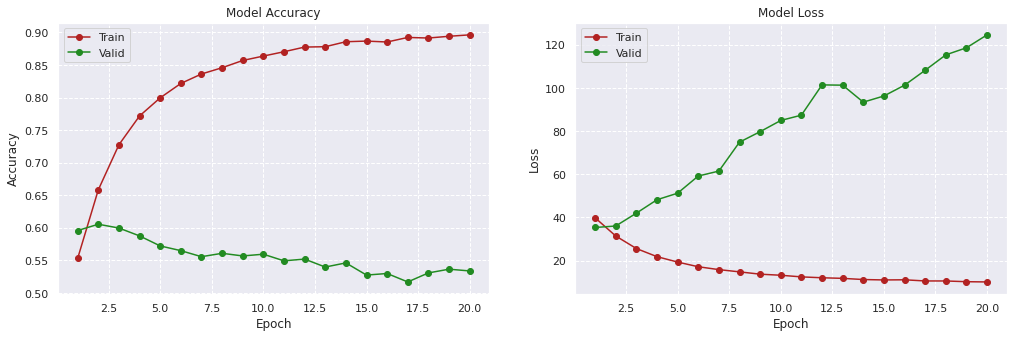

In [192]:
plot(estimator_embed, 'lstm_direct_embed')

In [193]:
y_prob = model.predict(X_test_input)
y_pred = y_prob.argmax(axis=-1)+1

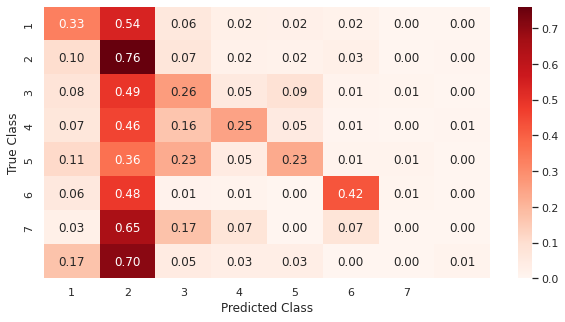

In [194]:
labels_train, labels_test = train_test_split(df['genre_principal'], test_size = 0.2, random_state = 42)
d = {'Comedy':1,
     'Drama':2,
     'Thriller':3,
     'Action':4,
     'Horror':5,
     'Documentary':6,
     'Crime':7,
     'Romance':8}

labels_test_code = [d[gen] for gen in labels_test ]
conf_matrix(labels_test_code, y_pred, 'conf_matrix_direct_embed')

In [195]:
y_testt = []
for i in range(len(y_test)):
    y_testt.append(y_test[i].argmax() +1)
print(classification_report(y_testt, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.33      0.40      1708
           2       0.60      0.76      0.67      3916
           3       0.27      0.26      0.26       732
           4       0.33      0.25      0.28       365
           5       0.28      0.23      0.25       321
           6       0.66      0.42      0.52       692
           7       0.00      0.00      0.00        40
           8       0.05      0.01      0.02        88

    accuracy                           0.53      7862
   macro avg       0.33      0.28      0.30      7862
weighted avg       0.52      0.53      0.51      7862



Le modèle overfit très vite mais les performances sont relativement bonnes : accuracy correct et prédiction un peu plus diversifiées.

### 2.1.2.2- Fasttext + LSTM

In [196]:
df = pd.read_csv("moviesdataset_firstclean.csv").drop(['Unnamed: 0'],1)
print(len(df))
df = df.dropna()
print(len(df))

39771
39310


In [197]:
X, y = np.array(df['overview']), np.array(df['genre_principal'])

from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_bin = label_binarize(df['genre_principal'], classes=list(df['genre_principal'].unique()))

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size = 0.8, random_state = 42, stratify = y)


Fastext embeddings

In [198]:
df['tokens'] = df['tokens'].apply(literal_eval)
l = list(df['tokens'])
ll = [item for sublist in l for item in sublist]

print("Nombre de token unique :",len(set(ll)))

# fasttext vectors can be imported through torch text (it will download it only once)
from gensim.models.fasttext import FastText
text_dim = 100

print("Training FastText model...")

ftext_model = FastText(list(df['tokens']),vector_size=100, window=40, min_count=1, workers=4,sg=1) 

print("FastText model created.")
print("%d unique words represented by %d dimensional vectors" % (len(ftext_model.wv.key_to_index), text_dim))

Nombre de token unique : 68257
Training FastText model...
FastText model created.
68257 unique words represented by 100 dimensional vectors


exemple de similarite avec fasttext :

In [199]:
print(ftext_model.wv.most_similar(positive=['love']))

[('lovea', 0.8568634390830994), ('lover', 0.835119903087616), ('lovelive', 0.8055959343910217), ('lovejoy', 0.7978761196136475), ('lovepotion', 0.7970771193504333), ('young', 0.7893391847610474), ('slove', 0.7780384421348572), ('loveand', 0.7766585946083069), ('plover', 0.7757503390312195), ('inlove', 0.7750106453895569)]


In [200]:
# save model in ASCII (word2vec) format
filename = 'embedding_fasttext.txt'
ftext_model.wv.save_word2vec_format(filename, binary=False)

In [201]:
# load embedding from file
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [202]:
raw_embedding = load_embedding('embedding_fasttext.txt')

Neural Network 

In [308]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class transformer_data_deep(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, df):
        encoded_docs = self.t.texts_to_sequences(np.array(df))
        #max_length = max([len(s) for s in encoded_docs])
        max_length = 100
        return pad_sequences(encoded_docs, maxlen= max_length, padding='post')

    def fit(self, df_train, y=None):
        self.t = Tokenizer()
        self.t.fit_on_texts(np.array(df_train))
        return self
    
        # create a weight matrix for the Embedding layer from a loaded embedding
    def get_weight_matrix(self, embedding):
        vocab = self.t.word_index
        # total vocabulary size plus 0 for unknown words
        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, 100))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            weight_matrix[i] = embedding.get(word)
        return weight_matrix, vocab_size

In [204]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

In [309]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, GRU, concatenate
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, Conv2D

kernel_size = 5
pool_size = 4
maxlen = 100

def build_model(raw_embedding):

    embedding_dim = 100
    inp = Input(shape=(maxlen, ))
    
    # get vectors in the right order
    embedding_vectors, vocab_size = transform.get_weight_matrix(raw_embedding)
       
    x = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=100, trainable=False)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))(x)
    x = Conv1D(filters = 64,
                 kernel_size = 5,
                 padding='valid',
                 activation='elu',
                 strides=1, kernel_initializer = "glorot_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool]) 
    preds = Dense(8, activation="softmax")(conc)
    
    model = Model(inputs = inp, outputs = preds)
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    model.compile(loss=loss, optimizer=opt, metrics=['acc'])
    return model

In [206]:
model = build_model(raw_embedding)  #('mlp')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     6040800     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 100, 100)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 128)    84480       ['spatial_dropout1d_1[0][0]

In [207]:
estimator_fastext = model.fit(X_train_input , y_train, epochs=20, validation_data = (X_test_input, y_test))

Epoch 1/20
983/983 [==============================] - 163s 161ms/step - loss: 35.6661 - acc: 0.5857 - val_loss: 34.5028 - val_acc: 0.5846
Epoch 2/20
983/983 [==============================] - 157s 160ms/step - loss: 32.9221 - acc: 0.6094 - val_loss: 33.0330 - val_acc: 0.5970
Epoch 3/20
983/983 [==============================] - 157s 160ms/step - loss: 32.4504 - acc: 0.6117 - val_loss: 32.3086 - val_acc: 0.6049
Epoch 4/20
983/983 [==============================] - 157s 159ms/step - loss: 32.2275 - acc: 0.6161 - val_loss: 33.1464 - val_acc: 0.6052
Epoch 5/20
983/983 [==============================] - 157s 160ms/step - loss: 31.9168 - acc: 0.6185 - val_loss: 33.0234 - val_acc: 0.6004
Epoch 6/20
983/983 [==============================] - 168s 171ms/step - loss: 31.6971 - acc: 0.6233 - val_loss: 32.2730 - val_acc: 0.6112
Epoch 7/20
983/983 [==============================] - 176s 180ms/step - loss: 31.3702 - acc: 0.6261 - val_loss: 32.7286 - val_acc: 0.6084
Epoch 8/20
983/983 [==============

In [208]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator_fastext.history['acc'][-1], 100*estimator_fastext.history['val_acc'][-1]))

Training accuracy: 64.90% / Validation accuracy: 59.76%


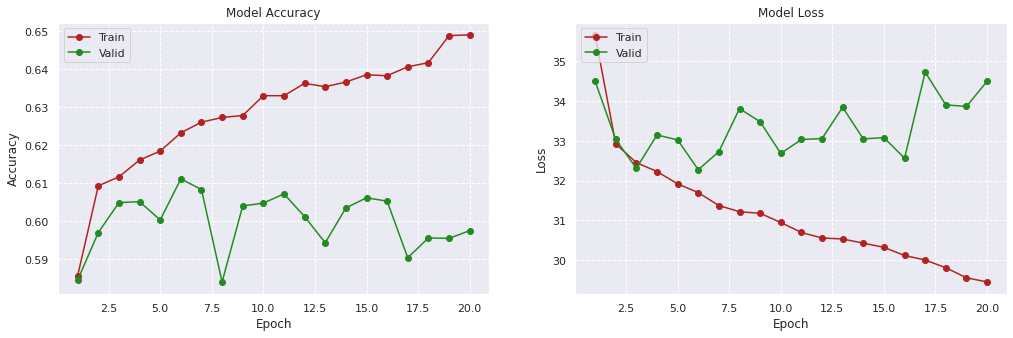

In [209]:
plot(estimator_fastext, 'lstm_direct_embed')

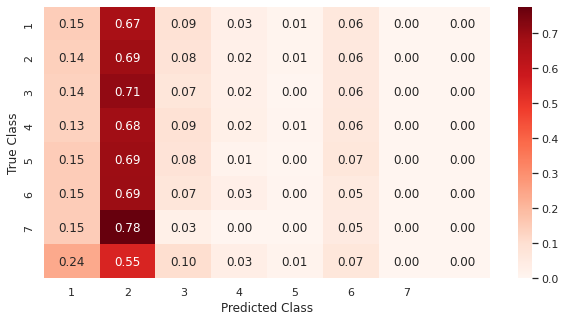

In [210]:
y_prob = model.predict(X_test_input)
y_pred = y_prob.argmax(axis=-1)+1

labels_train, labels_test = train_test_split(df['genre_principal'], test_size = 0.2, random_state = 42)
d = {'Comedy':1,
     'Drama':2,
     'Thriller':3,
     'Action':4,
     'Horror':5,
     'Documentary':6,
     'Crime':7,
     'Romance':8}

labels_test_code = [d[gen] for gen in labels_test ]
conf_matrix(labels_test_code, y_pred, 'conf_matrix_direct_embed')

In [211]:
y_testt = []
for i in range(len(y_test)):
    y_testt.append(y_test[i].argmax() +1)
print(classification_report(y_testt, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.38      0.45      1702
           2       0.62      0.85      0.72      3938
           3       0.35      0.31      0.33       737
           4       0.44      0.24      0.31       352
           5       0.42      0.06      0.11       326
           6       0.80      0.55      0.65       678
           7       0.00      0.00      0.00        46
           8       0.00      0.00      0.00        83

    accuracy                           0.60      7862
   macro avg       0.40      0.30      0.32      7862
weighted avg       0.57      0.60      0.56      7862



## 2.1.3- MODÈLE PRÉ-ENTRAINÉ : DistilBertForSequenceClassification

BERT, acronyme de Bidirectional Encoder Representations from Transformers, est un modèle de
langage développé par Google en 2018 permettant d’améliorer significativement les algorithmes de traitement automatique du langage ainsi que de traiter de nombreuses tâches importantes de NLP (classification, reconnaissance d’entités, réponse à des questions, etc.). Comme son nom l’indique, c’est une
méthode de représentation linguistique pré-entraînée de Transformers bidirectionnels profonds. La formation bidirectionnelle de Transformer est d’ailleurs sa principale innovation technique car elle contraste
avec les modèles qui traitent une séquence de texte soit de gauche à droite, soit une formation combinée
de gauche à droite et de droite à gauche. Ce modèle a donc une perception plus profonde du contexte et
du flux linguistique que les modèles de langage unidirectionnels (cf. annexe pour le détail du fonctionnement de BERT).

Le modèle de BERT peut être utilisé pour différentes tâches spécifiques en modifiant son architecture. Plus précisément, pour notre tâche de classification, nous prenons le modèle BERT pré-entraîné,
auquel nous ajoutons une couche de neurones non entraînés en sortie. Nous construisons ainsi un nouveau modèle adapté à notre tâche. Le processus d’entraînement de ce modèle sur nos données s’appelle
du "fine-tuning".

Nous choisissons d’utiliser DistilBERT qui est une version réduite de BERT disponible en open
source. Il s’agit d’une version plus légère et plus rapide ayant des performances très légèrement inférieures au modèle complet. Afin de travailler avec ce modèle, nous utilisons le package HuggingFace
de Transformers. Dans le but d’entraîner le modèle sur nos données, il est nécessaire de procéder en
deux étapes : d’une part la tokenisation (très spécifique au modèle) et d’autre part le fine-tuning (qui
correspond à l’entraînement de la dernière couche du modèle sur nos données).


In [7]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import tensorflow as tf
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import  GridSpec

In [8]:
df = pd.read_csv("moviesdataset_firstclean.csv")
df = df[['overview','genre_principal']]

d = {'Comedy':1,
     'Drama':2,
     'Thriller':3,
     'Action':4,
     'Horror':5,
     'Documentary':6,
     'Crime':7,
     'Romance':8}
df['label'] = df.genre_principal.apply(lambda x:d[x])

#### Tokenization avec Bert

On commence par déterminer la longueur maximale des phrases du texte, ce qui est nécessaire à la tokenizer avec DistilBERT. Chaque embedding a une taille fixe, celle correspondant à la phrase la plus longue de la base. 

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

sentences = df.overview.values
labels_init = df.label.values
#On fait démarer les classes à 0 dans le modèle (on a 8 classes de 0 à 7)
labels_init = labels_init-1

max_len = 0
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    

print('Max sentence length: ', max_len)

Max sentence length:  163


On tokenize. On récupère deux vecteurs : les inputs_ids (les embeddings) et les attention_masks (utile pour comprendre quels sont les embeddings qui sont nécessaires pour comprendre le sens de la phrase).

In [10]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
l_init = labels_init.tolist()
labels_init_tensor = torch.tensor(l_init)

ii = []
for j in range(len(input_ids)):
    ii.append(input_ids[j].tolist()[0])
    
input_ids_tensor = torch.tensor(ii)

aa = []
for j in range(len(attention_masks)):
    aa.append(attention_masks[j].tolist()[0])
    
attention_masks_tensor = torch.tensor(aa)

In [12]:
input_ids_tensor = input_ids_tensor.numpy()
labels_init_tensor = labels_init_tensor.numpy()
attention_masks_tensor = attention_masks_tensor.numpy()

input_ids_list=[]
for i in range(len(input_ids)):
    input_ids_list.append(input_ids[i].tolist()[0])
    
df['embeddings'] = input_ids_list
df.head()

,overview,genre_principal,label,embeddings
0,lead woody andys toy live happily room andys b...,Comedy,1,"[101, 2599, 13703, 5557, 2015, 9121, 2444, 113..."
1,family wedding reignite ancient feud nextdoor ...,Comedy,1,"[101, 2155, 5030, 5853, 4221, 3418, 13552, 227..."
2,cheat mistreat step woman hold breath wait elu...,Drama,2,"[101, 21910, 11094, 16416, 2102, 3357, 2450, 2..."
3,george bank recover daughter wedding receive n...,Comedy,1,"[101, 2577, 2924, 8980, 2684, 5030, 4374, 2739..."
4,obsessive master thief neil mccauley lead topn...,Drama,2,"[101, 27885, 8583, 12742, 3040, 12383, 6606, 2..."
...,...,...,...,...
39766,film archivist revisits story rustin parr herm...,Horror,5,"[101, 2143, 7905, 21997, 7065, 17417, 3215, 24..."
39767,version classic epic variation interesting sto...,Drama,2,"[101, 2544, 4438, 8680, 8386, 5875, 2466, 2839..."
39768,rise fall man woman,Drama,2,"[101, 4125, 2991, 2158, 2450, 102, 0, 0, 0, 0,..."
39769,artist struggle finish work storyline cult pla...,Drama,2,"[101, 3063, 5998, 3926, 2147, 9994, 8754, 2377..."


In [13]:
df.to_csv("movies_embeddings_bert.csv")

#### On divise la base en train test

In [14]:
df = pd.read_csv("movies_embeddings_bert.csv")

from sklearn.model_selection import train_test_split
train_size = int(0.9 * len(df))
val_size = len(df) - train_size

inputs_train, inputs_test, labels_train, labels_test, attention_masks_train, attention_masks_test = train_test_split(input_ids_tensor, labels_init_tensor, attention_masks_tensor, test_size = val_size, random_state = 42)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

35,793 training samples
3,978 validation samples


In [15]:
print(inputs_train[0])
print(labels_train[0])
print(attention_masks_train[0])

[  101  6789 13813  9304  3117  2309  2388 17623  2257  2919  2769  4788
  2272  2191  3247  3442 19217  2684  5754  3144  2152  2082  3076  7768
  2223  2004 16781 17623  5630  5308 13608 12218  4564 10250 10128  7323
  3959  5365  3112  5754  4982 10206  2388 20868  6072 26029 19307 17727
 23004  2126   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
1
[1 1 

#### On implémente le modèle DistilBertForSequenceClassification

In [16]:
nb_lab = 8
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = nb_lab)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [17]:
inputs_train, inputs_test, labels_train, labels_test, attention_masks_train, attention_masks_test = torch.tensor(inputs_train), torch.tensor(inputs_test), torch.tensor(labels_train), torch.tensor(labels_test), torch.tensor(attention_masks_train), torch.tensor(attention_masks_test)

On créer un torch DataLoader (un itérateur) pour notre base de données, afin d'économiser de la mémoire pendant le training.

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32 

train_data = TensorDataset(inputs_train, attention_masks_train, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(inputs_test, attention_masks_test, labels_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

lr = 2e-5
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1


optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = num_warmup_steps, 
                                            num_training_steps = num_total_steps)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


On fine-tune ce modèle pour un époque car le temps d'éxécution est trop long 

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random
import numpy as np
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
epochs = 4


In [ ]:
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        model.zero_grad()        
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss, logits = outputs[:2]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss, logits = outputs[:2]
        total_eval_loss += loss.item()
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
 
torch.save(model.state_dict(),'model1.h5')

Remarque : Le modèle a été entrainé dans un autre notebook, mais nous avons copié la cellule de sortie de l'entrainement ci-dessous :

In [ ]:
torch.save(model,'model1bis.h5')

In [21]:
MODEL = torch.load('model1bis.h5')

#### On récupére les prédictions du modèle sur la base test

In [24]:
validation_data = TensorDataset(inputs_test, attention_masks_test, labels_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, 
                                   sampler=validation_sampler, batch_size=batch_size)

In [26]:
outputs = model(b_input_ids, 
                               attention_mask=b_input_mask,
                               labels=b_labels)

In [30]:
logits.shape

(32, 8)

In [40]:
y_pred = np.array([])
y_test = np.array([])
for batch in validation_dataloader:
    b_input_ids = batch[0]
    b_input_mask = batch[1]
    b_labels = batch[2]
    with torch.no_grad():   
        outputs = model(b_input_ids, 
                               attention_mask=b_input_mask,
                               labels=b_labels)
        loss, logits = outputs[:2]
    logits = logits.detach().numpy()
    y_pred = np.concatenate((y_pred,np.argmax(logits,1)))
    y_test = np.concatenate((y_test,b_labels))

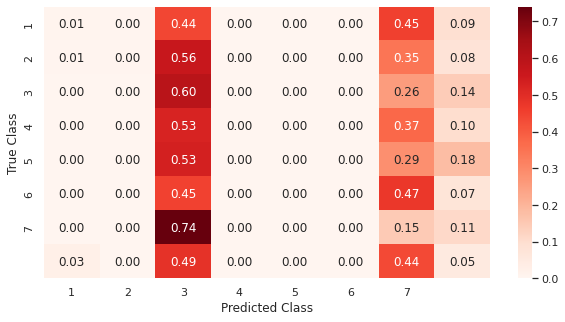

In [52]:
conf_matrix(y_test, y_pred, "DistillBertforsSequenceClassification")

In [53]:
#print(classification_report(y_pred,y_test))

Le modèle est assez décevant : meilleure accuracy mais il ne prédit que deux classes.


# 2.2- CLASSIFICATION : Multi-label classification

On peut tester une approche binaire : pour chaque genre, on calcul la probabilité que le film appartienne ou pas a ce genre.

La plupart des algorithmes d'apprentissage traditionnels sont développés pour des problèmes de classification à étiquette unique. C'est pourquoi de nombreuses approches dans la littérature transforment le problème à étiquettes multiples en plusieurs problèmes à étiquette unique, de sorte que les algorithmes à étiquette unique existants puissent être utilisés.

In [212]:
df = pd.read_csv(r"moviesdataset_firstclean.csv").drop(['Unnamed: 0'],1)

In [213]:
print(len(df))
df = df.dropna().reset_index().drop(['index'],1)
print(len(df))

39771
39310


In [214]:
df = df[['budget', 'popularity', 'revenue', 'vote_average',
       'vote_count', 'genre_principal', 'title', 'overview',
    'Animation', 'Comedy', 'Family', 'Adventure',
       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
       'Documentary', 'Western', 'TV Movie']]

In [215]:
var_a_pred = list(df['genre_principal'].unique())
g = df[var_a_pred]
nb_g = []
for i in range(len(g)):
    nb_g.append(g.iloc[i].sum())
g['nb_genre'] = nb_g

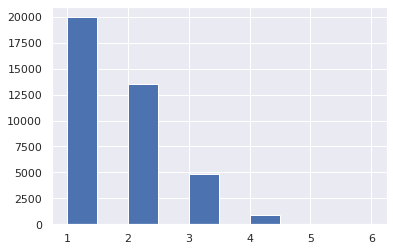

In [216]:
g['nb_genre'].hist()
plt.show()

In [217]:
#var_a_pred = list(df['genre_principal'].unique())
#['Animation', 'Comedy', 'Family', 'Adventure',
#       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
#       'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
#       'Documentary', 'Western', 'TV Movie']

#for var in var_a_pred:
#   print("Pour le genre",var,"il y a",len(df[df[var]==1]),"valeur 1.")

In [218]:
X, y = np.array(df['overview']), np.array(df[var_a_pred])
#'budget', 'revenue','popularity','vote_average','vote_count','title',


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42) #, stratify = y


## 2.2.1- LSTM

Ici, notre LSTM aura 8 neurones en sortie, mais on ne force pas la somme des probas a être égale à 1, on choisit la loss en conséquence : on fait de la classif multi-label : on choisit les genres qui ont une probabilité supérieur à 0.5.

In [232]:
class transformer_data_deep(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, df):
        encoded_docs = self.t.texts_to_sequences(np.array(df))
        #max_length = max([len(s) for s in encoded_docs])
        max_length = 60
        return pad_sequences(encoded_docs, maxlen= max_length, padding='post')

    def fit(self, df_train, y=None):
        self.t = Tokenizer()
        self.t.fit_on_texts(np.array(df_train))
        return self
    
        # create a weight matrix for the Embedding layer from a loaded embedding
    def get_weight_matrix(self, embedding):
        vocab = self.t.word_index
        # total vocabulary size plus 0 for unknown words
        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, 60))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            weight_matrix[i] = embedding.get(word)
        return weight_matrix, vocab_size

In [233]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

# Convolution
maxlen = 60
kernel_size = 5
filters = 64
pool_size = 4

def build_model_lstm():
    embedding_dim = 100
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(input_dim=len(transform.t.word_index) + 1, 
                               output_dim=embedding_dim, 
                               input_length=60)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))(x)
    x = Conv1D(filters = 64,
                 kernel_size = 5,
                 padding='valid',
                 activation='elu',
                 strides=1, kernel_initializer = "glorot_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool]) 
    preds = Dense(8, activation="sigmoid")(conc)
    
    model = Model(inputs = inp, outputs = preds)
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    model.compile(loss=loss, optimizer=opt, metrics=['acc'])
    
    #
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [234]:
model = build_model_lstm()  #('mlp')
#model.summary()

In [235]:
estimator_embed = model.fit(X_train_input, y_train, epochs=10, validation_data = (X_test_input, y_test))

Epoch 1/10
983/983 [==============================] - 138s 135ms/step - loss: 11.9202 - acc: 0.4980 - val_loss: 11.3469 - val_acc: 0.5382
Epoch 2/10
983/983 [==============================] - 133s 136ms/step - loss: 8.9169 - acc: 0.6234 - val_loss: 11.7932 - val_acc: 0.5321
Epoch 3/10
983/983 [==============================] - 133s 136ms/step - loss: 6.9385 - acc: 0.6726 - val_loss: 13.3963 - val_acc: 0.5219
Epoch 4/10
983/983 [==============================] - 134s 137ms/step - loss: 5.7763 - acc: 0.6875 - val_loss: 14.5743 - val_acc: 0.4968
Epoch 5/10
983/983 [==============================] - 134s 136ms/step - loss: 4.9703 - acc: 0.6925 - val_loss: 17.3053 - val_acc: 0.5042
Epoch 6/10
983/983 [==============================] - 134s 136ms/step - loss: 4.4443 - acc: 0.7036 - val_loss: 17.9270 - val_acc: 0.4849
Epoch 7/10
983/983 [==============================] - 134s 136ms/step - loss: 4.0872 - acc: 0.7019 - val_loss: 19.7479 - val_acc: 0.4769
Epoch 8/10
983/983 [====================

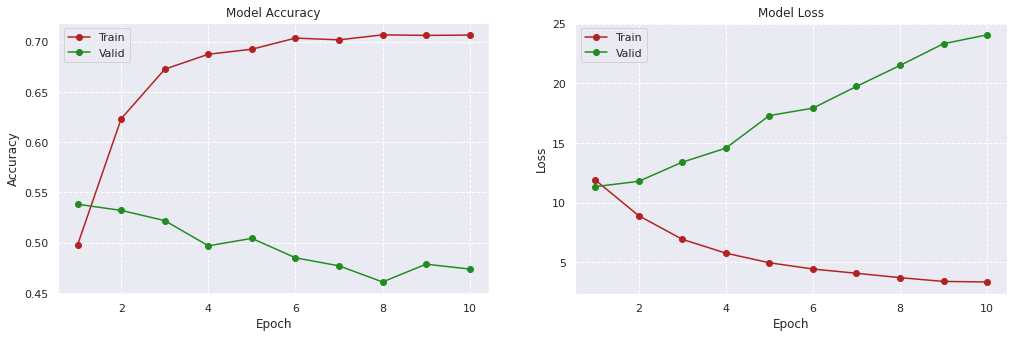

In [236]:
plot(estimator_embed, 'lstm_direct_embed')

In [237]:
y_prob = model.predict(X_test_input)
#y_pred = (y_prob*2)//1
#y_pred = y_pred.astype(np.int64)

In [238]:
y_pred = []
for i in range(y_prob.shape[0]):
    p = []
    for j in range(y_prob.shape[1]):
        if y_prob[i,j]>=0.5:
            p.append(1)
        else:
            p.append(0)
    y_pred.append(p)

In [239]:
# egalite stricte
acc = 0
for i in range(len(y_pred)):
    if (y_pred[i]==y_test[i]).all() == True:
        acc +=1
    
print(acc/len(y_pred))

0.23365555838209107


In [240]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_pred) #,labels=var_a_pred

array([[[4170, 1216],
        [ 946, 1530]],

       [[2625, 1321],
        [1400, 2516]],

       [[5624,  714],
        [ 897,  627]],

       [[6067,  486],
        [ 730,  579]],

       [[6653,  275],
        [ 431,  503]],

       [[6915,  166],
        [ 357,  424]],

       [[6778,  271],
        [ 599,  214]],

       [[5884,  661],
        [ 841,  476]]])

In [241]:
label_names = var_a_pred

print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

      Comedy       0.56      0.62      0.59      2476
       Drama       0.66      0.64      0.65      3916
    Thriller       0.47      0.41      0.44      1524
      Action       0.54      0.44      0.49      1309
      Horror       0.65      0.54      0.59       934
 Documentary       0.72      0.54      0.62       781
       Crime       0.44      0.26      0.33       813
     Romance       0.42      0.36      0.39      1317

   micro avg       0.57      0.53      0.55     13070
   macro avg       0.56      0.48      0.51     13070
weighted avg       0.57      0.53      0.54     13070
 samples avg       0.57      0.57      0.54     13070



In [242]:
hamming_score(y_test, y_pred, normalize=True, sample_weight=None)

0.45569193589417445

Remarque : sur les 20 genres ca marche pas, on test surtout sur les 8 genres.

## 2.2.2- Ensemble of Binary Classifiers (One-vs-Rest)

In [243]:
df = pd.read_csv('moviesdataset_firstclean.csv')
df = df.dropna().reset_index().drop(['index'],1)
var_a_predire = ['Comedy', 'Drama', 'Thriller', 'Action', 'Horror', 'Documentary','Crime', 'Romance']
X, y = np.array(df[['budget', 'revenue',
                    'popularity','vote_average',
                    'vote_count', 'title','overview']]), np.array(df[var_a_predire])


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
# est-ce qu'on garde que le vocabulaire correspondant au X_train ?
#df['voc'] = df['overview'] + ' ' + df['title']
#voc = np.array(df['voc'])
voc = np.array(df['overview'])

In [244]:
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

pipeline_OneVsRestClassifier_rf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric),('scale', StandardScaler())
             ])),
             ('title_features', Pipeline([
                ('selector', title_transformer_text),
                ("word2vec vectorizer",CountVectorizer(analyzer=lambda x: x) ) #MeanEmbeddingVectorizer(glove_small)
            ])),
             ('overview_features', Pipeline([
                ('selector', overview_transformer_text),
                ("word2vec vectorizer", CountVectorizer(analyzer=lambda x: x))
            ]))
         ])),
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

In [245]:
#on entraine le modèle

rf_OneVsRestClassifier_model = pipeline_OneVsRestClassifier_rf
rf_OneVsRestClassifier_model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_numeric_data at 0x7f6952679b80>)),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('title_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function get_title_data at 0x7f6952679af0>)),
                                                                 ('word2vec '
                                                                  'vectorizer',
                                                                  CountVectorize

In [246]:
y_pred = rf_OneVsRestClassifier_model.predict(X_test)

In [247]:
accuracy_score(y_test, y_pred)

0.13050114474688373

In [248]:
label_names = var_a_pred
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

      Comedy       0.64      0.03      0.06      2476
       Drama       0.63      0.62      0.62      3916
    Thriller       0.38      0.00      0.00      1524
      Action       0.78      0.03      0.05      1309
      Horror       0.00      0.00      0.00       934
 Documentary       0.80      0.03      0.05       781
       Crime       0.00      0.00      0.00       813
     Romance       0.00      0.00      0.00      1317

   micro avg       0.63      0.20      0.30     13070
   macro avg       0.40      0.09      0.10     13070
weighted avg       0.48      0.20      0.21     13070
 samples avg       0.32      0.22      0.25     13070



In [249]:
hamming_score(y_test, y_pred, normalize=True, sample_weight=None)

0.21556643771728992

---------------------------------------------------------------------------------------------------------------
# 3- DATA AUGMENTATION : par Back translation

### Fonctions pour la data augmentation

In [1]:
#pip install transformers
#pip install mosestokenizer
#!pip install sentencepiece

In [2]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import pandas as pd

2022-04-23 18:41:08.805419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 18:41:08.805452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Get the name of the first model
first_model_name = 'Helsinki-NLP/opus-mt-en-fr'

# Get the tokenizer
first_model_tkn = MarianTokenizer.from_pretrained(first_model_name)

# Load the pretrained model based on the name
first_model = MarianMTModel.from_pretrained(first_model_name)

In [4]:
# Get the name of the second model
second_model_name = 'Helsinki-NLP/opus-mt-fr-en'

# Get the tokenizer
second_model_tkn = MarianTokenizer.from_pretrained(second_model_name)

# Load the pretrained model based on the name
second_model = MarianMTModel.from_pretrained(second_model_name)

In [5]:
def format_batch_texts(language_code, batch_texts):
    formated_bach = [">>{}<< {}".format(language_code, text) for text in batch_texts]
    return formated_bach

In [7]:
def perform_translation(batch_texts, model, tokenizer, language="fr"):
    # Prepare the text data into appropriate format for the model
    formated_batch_texts = format_batch_texts(language, batch_texts)
    
    # Generate translation using model
    translated = model.generate(**tokenizer(formated_batch_texts, return_tensors="pt", padding=True))
    
    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    
    return translated_texts


In [9]:
def combine_texts(original_texts, back_translated_batch):
    return set(original_texts + back_translated_batch) 

In [10]:
#combine_texts(original_texts, back_translated_texts)

In [11]:
def perform_back_translation_with_augmentation(batch_texts, original_language="en", temporary_language="fr"):
    # Translate from Original to Temporary Language
    print("Performing translation to french")
    tmp_translated_batch = perform_translation(batch_texts, first_model, first_model_tkn, temporary_language)
    #print(tmp_translated_batch)
    # Translate Back to English
    print("Performing translation back to english")
    back_translated_batch = perform_translation(tmp_translated_batch, second_model, second_model_tkn, original_language)
    #return back_translated_batch
    #Return The Final Result
    #print(back_translated_batch)
    return list(combine_texts(batch_texts, back_translated_batch))

# Execute the function for Data Augmentation
#final_augmented = perform_back_translation_with_augmentation(original_texts)
#print(final_augmented)

### Data augmentation sur les classes minoritaires 

In [12]:
df = pd.read_csv("movies_for_DA.csv").drop(['Unnamed: 0'],1)
genres_to_keep = ['Comedy', 'Drama', 'Thriller', 'Action', 'Horror', 'Documentary',
                  'Crime', 'Romance']
df = df[df['genre_principal'].isin(genres_to_keep)]
#print(len(df))
#df['genre_principal'].unique()

/tmp/ipykernel_876/2050414053.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = pd.read_csv("movies_for_DA.csv").drop(['Unnamed: 0'],1)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


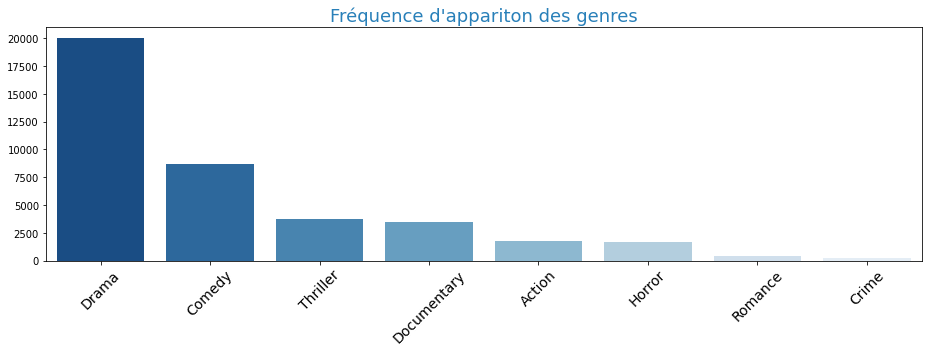

In [19]:
import collections
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

all_genres = df.genre_principal.values
all_genres = list(all_genres)
occ_genres = Counter(all_genres)
occ_genres_sorted = dict(sorted(occ_genres.items(), key=lambda item: item[1],reverse=True))

plt.figure(figsize = (13,5))
sns.barplot(list(occ_genres_sorted.keys()),list(occ_genres_sorted.values()),palette="Blues_r")
plt.tick_params(axis = 'x', labelsize = 14)
plt.title("Fréquence d'appariton des genres", fontsize=18, color='#2980b9')
plt.xticks(rotation= 45)
plt.tight_layout()

In [21]:
import numpy as np
for genre in ['Action','Horror']:
    to_dataaugm = list(df[df['genre_principal']==genre]['overview'])
    print("On va augmenter",len(to_dataaugm),"films du genre",genre,".")
    splits = np.array_split(to_dataaugm, 20)
    nb_l = len(splits)
    i = 0
    data_augm_df = pd.DataFrame(columns=['overview_augmented'])
    for split in splits:
        print("--Calculs des",round((i/nb_l)*100),"% des films à augmenter :--")
        bis = pd.DataFrame(columns=['overview_augmented'])
        i+=1 
        split = list(split)
        data_augm = perform_back_translation_with_augmentation(split, temporary_language="fr")
        print('--',round((i/nb_l)*100),"des films sont traités.--")
        bis['overview_augmented'] = data_augm
        data_augm_df = pd.concat([data_augm_df,bis])
        data_augm_df.to_csv("data_augmented_%s_fr.csv"%genre)

    data_augm_df['genre_principal'] = genre
    data_augm_df = data_augm_df.reset_index()
    data_augm_df = data_augm_df.drop(['index'],1)
    data_augm_df.to_csv("Data augmented/data_augmented_%s_fr.csv"%genre)


On va augmenter 1770 films du genre Action .
--Calculs des 0 % des films à augmenter :--
Performing translation to french
Performing translation back to english
-- 5 des films sont traités.--
--Calculs des 5 % des films à augmenter :--
Performing translation to french
Performing translation back to english
-- 10 des films sont traités.--
--Calculs des 10 % des films à augmenter :--
Performing translation to french
Performing translation back to english
-- 15 des films sont traités.--
--Calculs des 15 % des films à augmenter :--
Performing translation to french
Performing translation back to english
-- 20 des films sont traités.--
--Calculs des 20 % des films à augmenter :--
Performing translation to french
Performing translation back to english
-- 25 des films sont traités.--
--Calculs des 25 % des films à augmenter :--
Performing translation to french
Performing translation back to english
-- 30 des films sont traités.--
--Calculs des 30 % des films à augmenter :--
Performing translat

Token indices sequence length is longer than the specified maximum sequence length for this model (788 > 512). Running this sequence through the model will result in indexing errors


-- 90 des films sont traités.--
--Calculs des 90 % des films à augmenter :--
Performing translation to french


IndexError: index out of range in self

### Construction de la table data augmentée

Dans un premier temps, on garde 3000 films par classe.

In [251]:
df = pd.read_csv("movies_for_DA.csv").drop(['Unnamed: 0'],1)
genres_to_keep = ['Comedy', 'Drama', 'Thriller', 'Action', 'Horror', 'Documentary',
                  'Crime', 'Romance']
df = df[df['genre_principal'].isin(genres_to_keep)]


In [289]:
data_augmented_df = pd.DataFrame(columns=['overview','genre_principal'])

In [290]:
for genre in  ['Comedy', 'Drama', 'Thriller', 'Documentary']:
    data_augmented_df = pd.concat([df[df['genre_principal']==genre].sample(3000),data_augmented_df])

data_augmented_df = pd.concat([df[df['genre_principal']=='Horror'],data_augmented_df])

In [291]:
t = pd.read_csv("Data augmented/data_augmented_Action_fr.csv").drop(['Unnamed: 0'],1)
t = t.rename(columns={'overview_augmented':'overview'})
t['genre_principal'] = 'Action'
data_augmented_df = pd.concat([data_augmented_df,t])

data_augmented_df = data_augmented_df.reset_index().drop(['index'],1)

In [292]:
for genre in ['Crime','Romance']:
    t = pd.read_csv("Data augmented/data_augmented_%s_fr.csv"%genre).drop(['Unnamed: 0'],1)
    t = t.rename(columns={'overview_augmented':'overview'})
    t['genre_principal'] = genre
    data_augmented_df = pd.concat([data_augmented_df,t])
    
    tt = pd.read_csv("Data augmented/data_augmented_%s_es.csv"%genre).drop(['Unnamed: 0'],1)
    tt = tt.rename(columns={'overview_augmented':'overview'})
    tt['genre_principal'] = genre
    data_augmented_df = pd.concat([data_augmented_df,tt])
    
    ttt = pd.read_csv("Data augmented/data_augmented_%s_al.csv"%genre).drop(['Unnamed: 0'],1)
    ttt = ttt.rename(columns={'overview_augmented':'overview'})
    ttt['genre_principal'] = genre
    data_augmented_df = pd.concat([data_augmented_df,ttt])

data_augmented_df = data_augmented_df.reset_index().drop(['index'],1)

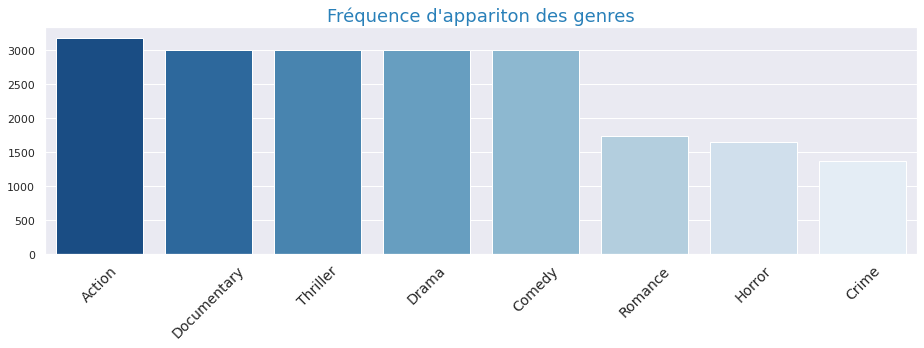

In [293]:
all_genres = data_augmented_df.genre_principal.values
all_genres = list(all_genres)
occ_genres = Counter(all_genres)
occ_genres_sorted = dict(sorted(occ_genres.items(), key=lambda item: item[1],reverse=True))

plt.figure(figsize = (13,5))
sns.barplot(list(occ_genres_sorted.keys()),list(occ_genres_sorted.values()),palette="Blues_r")
plt.tick_params(axis = 'x', labelsize = 14)
plt.title("Fréquence d'appariton des genres", fontsize=18, color='#2980b9')
plt.xticks(rotation= 45)
plt.tight_layout()

### Cleaning de la table data augmentée

In [294]:
data_augmented_df['overview'] = data_augmented_df.overview.apply(clean)

In [295]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Repeating the earlier vocabulary count
arr = data_augmented_df.overview.apply(lambda x: [w.text for w in tokenizer(x)]).array
data_augmented_df['tokens'] = arr
arr_s = [ x for X in arr for x in X]
print("Vocabulary size with Spacy's tokenizer: {}".format(len(set(arr_s))))

# Inspecting a tokenization sample
tokenization_sample = data_augmented_df.overview.head().apply(lambda x: 
                                              [w.text for w in tokenizer(x)])
print("Tokenization sample:\n {}".format(tokenization_sample))

Vocabulary size with Spacy's tokenizer: 42606
Tokenization sample:
 0    [sirius, year, distant, mining, planet, ravage...
1    [experiment, go, awry, place, neurologist, eli...
2    [candyman, move, new, orleans, start, horrific...
3    [shipwreck, sailor, stumble, mysterious, islan...
4    [group, people, try, survive, attack, bloodthi...
Name: overview, dtype: object


### Application au modèle Fastext + LSTM 

In [296]:
X, y = np.array(data_augmented_df['overview']), np.array(data_augmented_df['genre_principal'])

from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_bin = label_binarize(data_augmented_df['genre_principal'], classes=list(data_augmented_df['genre_principal'].unique()))

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size = 0.8, random_state = 42, stratify = y)


In [297]:
#data_augmented_df['tokens'] = data_augmented_df['tokens'].apply(literal_eval)
l = list(data_augmented_df['tokens'])
ll = [item for sublist in l for item in sublist]

print("Nombre de token unique :",len(set(ll)))

# fasttext vectors can be imported through torch text (it will download it only once)
from gensim.models.fasttext import FastText
text_dim = 100

print("Training FastText model...")

ftext_model = FastText(list(data_augmented_df['tokens']),vector_size=100, window=40, min_count=1, workers=4,sg=1) 

print("FastText model created.")
print("%d unique words represented by %d dimensional vectors" % (len(ftext_model.wv.key_to_index), text_dim))

Nombre de token unique : 42606
Training FastText model...
FastText model created.
42606 unique words represented by 100 dimensional vectors


In [298]:
# save model in ASCII (word2vec) format
filename = 'dataaugm_embedding_fasttext.txt'
ftext_model.wv.save_word2vec_format(filename, binary=False)

In [299]:
# load embedding from file
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

raw_embedding = load_embedding('dataaugm_embedding_fasttext.txt')

In [310]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

In [312]:
model = build_model(raw_embedding)  #('mlp')
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 100, 100)     3818000     ['input_11[0][0]']               
                                                                                                  
 spatial_dropout1d_9 (SpatialDr  (None, 100, 100)    0           ['embedding_9[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 100, 128)    84480       ['spatial_dropout1d_9[0][0]

In [313]:
estimator_fastext = model.fit(X_train_input , y_train, epochs=10, validation_data = (X_test_input, y_test))

Epoch 1/10
499/499 [==============================] - 84s 160ms/step - loss: 50.3127 - acc: 0.4142 - val_loss: 45.0406 - val_acc: 0.4757
Epoch 2/10
499/499 [==============================] - 79s 159ms/step - loss: 43.7768 - acc: 0.4903 - val_loss: 42.3603 - val_acc: 0.5063
Epoch 3/10
499/499 [==============================] - 79s 159ms/step - loss: 40.5972 - acc: 0.5236 - val_loss: 43.6312 - val_acc: 0.4922
Epoch 4/10
499/499 [==============================] - 79s 159ms/step - loss: 38.1973 - acc: 0.5562 - val_loss: 42.1710 - val_acc: 0.5133
Epoch 5/10
499/499 [==============================] - 79s 159ms/step - loss: 36.1550 - acc: 0.5770 - val_loss: 37.5460 - val_acc: 0.5607
Epoch 6/10
499/499 [==============================] - 79s 159ms/step - loss: 34.4662 - acc: 0.5965 - val_loss: 37.6127 - val_acc: 0.5629
Epoch 7/10
499/499 [==============================] - 79s 159ms/step - loss: 32.8791 - acc: 0.6114 - val_loss: 37.1295 - val_acc: 0.5712
Epoch 8/10
499/499 [=====================

### Analyse de la performance du modèle

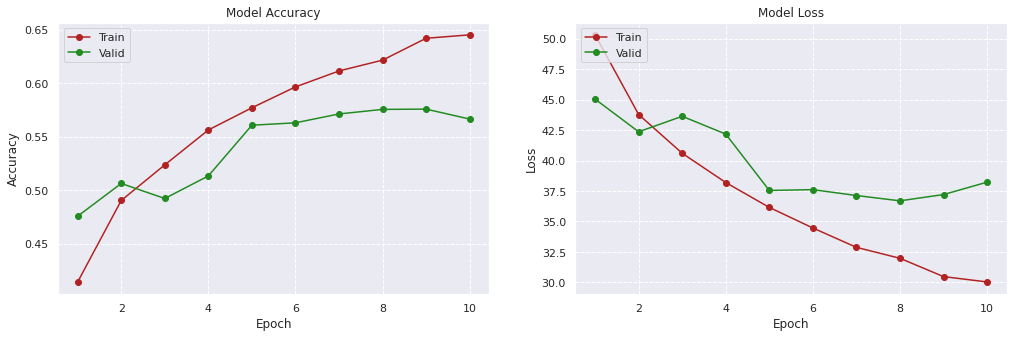

In [314]:
plot(estimator_fastext, 'lstm_direct_embed')

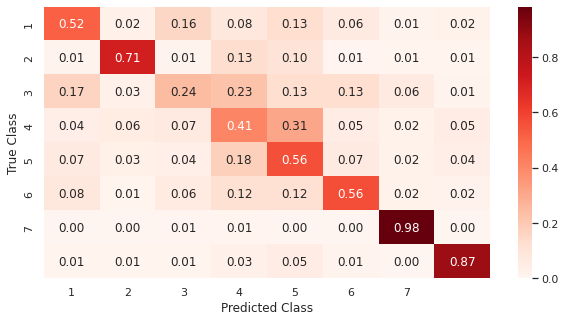

In [315]:
y_prob = model.predict(X_test_input)
y_pred = y_prob.argmax(axis=-1)+1
y_test_test = y_test.argmax(axis=-1)+1

labels_train, labels_test = train_test_split(df['genre_principal'], test_size = 0.2, random_state = 42)
d = {'Comedy':1,
     'Drama':2,
     'Thriller':3,
     'Action':4,
     'Horror':5,
     'Documentary':6,
     'Crime':7,
     'Romance':8}

labels_test_code = [d[gen] for gen in labels_test ]
conf_matrix(y_test_test, y_pred, 'conf_matrix_direct_embed')

In [316]:
y_testt = []
for i in range(len(y_test)):
    y_testt.append(y_test[i].argmax() +1)
print(classification_report(y_testt, y_pred))

              precision    recall  f1-score   support

           1       0.43      0.52      0.47       329
           2       0.83      0.71      0.77       600
           3       0.47      0.24      0.32       600
           4       0.36      0.41      0.38       600
           5       0.42      0.56      0.48       600
           6       0.67      0.56      0.61       636
           7       0.75      0.98      0.85       274
           8       0.78      0.87      0.82       349

    accuracy                           0.57      3988
   macro avg       0.59      0.61      0.59      3988
weighted avg       0.58      0.57      0.56      3988



On voit bien que la data augmentation permet largement d'améliorer les performances sur les petites classes. La performance globale est moins bonne mais c'est tout à fait logique compte tenu du fait qu'on on ne teste le modèle que sur une petite fraction de la base. On peut vraiment espérer grandement améliorer les performances en effectuant de la data augmentation sur toute la base.